In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import pickle
import statsmodels.api as sm
import math
import yfinance as yf
from newspaper import Article
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow import keras
from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import  LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Activation
import tensorflow as tf




import pytorch_lightning as pl
from pytorch_forecasting import NHiTS, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE
from sklego.preprocessing import RepeatingBasisFunction   
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from datetime import datetime
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet





from transformers import  AutoModelForSequenceClassification
from transformers import BertTokenizer
import torch
from transformers import pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


# FUNCTIONS

In [2]:
def best_feature_selector(df, target_column):

    '''
    Function to that applies
    Select KBest technique to select 
    the features with strongest impact 
    on target variable
    '''

    y = df[target_column]
    x = df.drop(columns = target_column)

    select = SelectKBest(score_func=f_regression, k=10)
    best = select.fit_transform(x, y)

    filter = select.get_support()
    features = np.array(x.columns)
    
    print("Top 10 features:")
    print(features[filter])
    print(best)  

    

def dot_rem(df, column):

    '''
    Function to remove 
    special characters
    from string
    '''

    subs = df[column] == "."
    df.loc[subs, column] = np.nan
    df[column] = df[column].astype('float')

    return df

def log_ret(df, column, index):

    '''
    Function to calculate 
    log returns
    '''

    df[f'Return_{index}'] = np.log(df[column]) - np.log(df[column].shift(1))
    df.dropna(inplace=True)
    df.drop(columns=column, inplace=True)

    return df


def y_data_downloader(tick, start_date, end_date, tickname):

    '''
    Function to download data from
    YFinance
    '''

    y_df = yf.download(tick, start=start_date, end=end_date)
    y_df.reset_index(inplace=True)
    y_df.Date = pd.to_datetime(y_df.Date, format='%Y%m%d')
    y_df['Date'] = y_df['Date'].dt.tz_localize(None) 
    y_df = y_df[['Date', 'Close']]
    y_df['Close'] = y_df['Close'].shift(-1)
    log_ret(y_df, 'Close', tickname)

    return y_df



def sentiment_analyzier(df):

    '''
    
    '''

    lis =[]
    for ind in df.index:
        dict={}
        try:
            article = Article(df['link'][ind])
            article.download()
            article.parse()
            article.nlp()
        except:
            pass
    
        dict['Date']=df['date'][ind]
        dict['Media']=df['media'][ind]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        lis.append(dict)

    news_df=pd.DataFrame(lis)

    nlp_all = pd.DataFrame()
    for i, c in zip(news_df['Summary'], news_df['Date']):

        analyzer = SentimentIntensityAnalyzer().polarity_scores(i)

        neg = analyzer['neg']
        pos = analyzer['pos']
        neu = analyzer['neu']
        comp = analyzer['compound']

        nlp_all = nlp_all.append({'Date':c,'Text':i, 'Negative_sent':neg, 'Positive_sent':pos, 'Neutral_sent':neu, 'Compounded':comp}, ignore_index=True)

    correct_m = {
        'an':'Jan',
        'eb':'Feb',
        'ar':'Mar', 
        'pr':'Apr',
        'ay':'May',
        'un':'Jun',
        'ul':'Jul', 
        'ug':'Aug', 
        'ep':'Sep',
        'ct':'Oct',
        'ov':'Nov',
        'ec':'Dec'
    }

    correct_m_2 = {
        'SS':'S',
        'DD':'D',
        'AA':'A',
        'NN':'N',
        'MM':'M',
        'JJ':'J',
        'FF':'F'
    }

    for char in correct_m.keys():
        
        nlp_all.Date = nlp_all.Date.str.replace(char, correct_m[char])

    for char in correct_m_2.keys():
        
        nlp_all.Date = nlp_all.Date.str.replace(char, correct_m_2[char]) 

    nlp_all = nlp_all[nlp_all.Date!='2 weeks ago']

    nlp_all['splt'] = nlp_all.Date.str.split(' ').str[0]
    nlp_all['splt'] = nlp_all['splt'].apply(lambda x: x[1:] if len(x)>3 else x)
    nlp_all['Date1'] = nlp_all['Date'].str.split().str[1:].str.join('')

    nlp_all['Date'] = nlp_all['splt'] + ' ' + nlp_all['Date1']
    nlp_all.Date = pd.to_datetime(nlp_all.Date, format='%b %d,%Y')

    nlp_all = nlp_all[['Negative_sent', 'Positive_sent', 'Neutral_sent', 'Compounded', 'Date']]
    nlp_all.Date = pd.to_datetime(nlp_all.Date)

    nlp_all['Week'] = nlp_all.Date.dt.weekofyear
    nlp_all['Year'] = nlp_all.Date.dt.year
    nlp_all = nlp_all.groupby(['Week', 'Year']).agg({'Negative_sent':'sum', 'Positive_sent':'sum', 'Neutral_sent':'sum', 'Compounded':'sum'}).reset_index()


    return nlp_all


def pq_arima_finder(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


def plot_rmse(model):

  '''
  Function to plot RMSE
  '''
  
  fig = plt.figure(figsize=(20,7))
  fig.add_subplot(121)
  plt.plot(model.epoch, model.history['root_mean_squared_error'], label = "rmse")
  plt.plot(model.epoch, model.history['val_root_mean_squared_error'], label = "val_rmse")

  plt.title("RMSE", fontsize=18)
  plt.xlabel("Epochs", fontsize=15)
  plt.ylabel("RMSE", fontsize=15)
  plt.grid(alpha=0.3)
  plt.legend()

  fig.add_subplot(122)

  plt.plot(model.epoch, model.history['loss'], label="loss")
  plt.plot(model.epoch, model.history['val_loss'], label="val_loss")

  plt.title("Loss", fontsize=18)
  plt.xlabel("Epochs", fontsize=15)
  plt.ylabel("Loss", fontsize=15)
  plt.grid(alpha=0.3)
  plt.legend()

  plt.show()


def compare_plot(original_df, predictions_df, color_real, color_pred):

  '''
  Function to plot predictions 
  and to compare them with real returns
  '''

  plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
  plt.grid(True)

  plt.plot(original_df, color=color_real, label='Real Returns of Oil Futures Contract')
  plt.plot(predictions_df, color=color_pred, label='Prediction of Returns of Oil Futures Contract')
  #plt.axvline(x = x, color = 'b', label = 'axvline - full height')

  plt.legend(loc='best')


def return_prediction(X_test,y_test, X_train,y_train , full_df, model, name, how):

  '''
  Function to create predictions based on trained models
  '''

  if how=='price':

    y_pred = model.predict(X_test)

    y_pred_train = model.predict(X_train)

    predictions_inversed = np.repeat(y_pred, full_df.shape[1], axis=-1)
    predictions = sc.inverse_transform(predictions_inversed)[:,0]

    train_inversed = np.repeat(y_pred_train, full_df.shape[1], axis=-1)
    train_pred = sc.inverse_transform(train_inversed)[:,0]

    train_inversed_real = np.repeat(y_train, full_df.shape[1], axis=-1)
    train_real = sc.inverse_transform(train_inversed_real)[:,0]

    real_inversed = np.repeat(y_test, full_df.shape[1], axis=-1)
    real = sc.inverse_transform(real_inversed)[:,0]

    compare_df = pd.DataFrame({'Real_value':real, 'Predicted_value':predictions})
    compare_df_train = pd.DataFrame({'Real_value':train_real, 'Predicted_value':train_pred})

    # ####ONE BIG PLOT
    # compare_df1 = pd.concat([ compare_df_train, compare_df], axis=0)
    # compare_df1 = compare_df1.reset_index(drop=True)

    ####END

    compare_plot(compare_df.Real_value, compare_df.Predicted_value, 'orange', 'grey')
    compare_plot(compare_df_train.Real_value, compare_df_train.Predicted_value, 'green', 'grey')
    compare_df.dropna(inplace=True)
    compare_df.to_csv(f'predictions_{name}.csv')
  
  if how=='return':

    y_pred = model.predict(X_test)

    y_pred_train = model.predict(X_train)

    predictions_inversed = np.repeat(y_pred, full_df.shape[1], axis=-1)
    predictions = sc.inverse_transform(predictions_inversed)[:,0]

    train_inversed = np.repeat(y_pred_train, full_df.shape[1], axis=-1)
    train_pred = sc.inverse_transform(train_inversed)[:,0]

    train_inversed_real = np.repeat(y_train, full_df.shape[1], axis=-1)
    train_real = sc.inverse_transform(train_inversed_real)[:,0]

    real_inversed = np.repeat(y_test, full_df.shape[1], axis=-1)
    real = sc.inverse_transform(real_inversed)[:,0]

    compare_df = pd.DataFrame({'Real_value':real, 'Predicted_value':predictions})
    compare_df = compare_df.reset_index(drop=True)
    compare_df['Real_value'] = np.log(compare_df['Real_value']).diff()
    compare_df['Predicted_value'] = np.log(compare_df['Predicted_value']).diff()

    compare_df_train = pd.DataFrame({'Real_value':train_real, 'Predicted_value':train_pred})
    compare_df_train = compare_df_train.reset_index()
    compare_df_train['Real_value'] = np.log(compare_df_train['Real_value']).diff()
    compare_df_train['Predicted_value'] = np.log(compare_df_train['Predicted_value']).diff()

    ####ONE BIG PLOT
    # compare_df1 = pd.concat([ compare_df_train, compare_df], axis=0)
    # compare_df1 = compare_df1.reset_index(drop=True)

    ####END

    compare_plot(compare_df.Real_value, compare_df.Predicted_value ,'orange', 'grey')

    compare_plot(compare_df_train.Real_value, compare_df_train.Predicted_value, 'green', 'grey')

    #compare_df = compare_df.reset_index(drop=True).dropna()
    compare_df.dropna(inplace=True)
    
    compare_df.to_csv(f'predictions_{name}.csv')

  
  return compare_df


def create_data_train(df, n_future, n_past):
  
  '''
  Function to create rolling windows
  for training data
  
  '''

  n_feature = df.shape[1]
  x_train, y_train = [], []
  
  for i in range(n_past, len(df) - n_future + 1):
    x_train.append(df[i - n_past:i, 0:n_feature])
    y_train.append(df[i + n_future - 1:i + n_future, 0]) 
  
  return np.array(x_train), np.array(y_train)


def create_data_test(df, n_future, n_past):

  '''
  Function to create rolling windows 
  for testing data
  '''

  n_feature = df.shape[1]
  x_test, y_test = [], []
  
  for i in range(n_past, len(df) - n_future + 1):

    x_test.append(df[i - n_past:i, 0:n_feature])
    y_test.append(df[i + n_future - 1:i + n_future, 0])
  
  return np.array(x_test), np.array(y_test)


def build_model_lstm_univariate(hp):

  ''''
  Function to optimize the lstm model
  '''

  model = Sequential()

  model.add(LSTM(hp.Int('input_unit' ,min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train_uni.shape[1],X_train_uni.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 4)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=256, step=32), return_sequences=True, input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


def build_model_cnn_univariate(hp):

  '''
  Function to optimize cnn model
  '''
   
  model = keras.models.Sequential()
  
  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=512,
                              step=32),kernel_size= hp.Int(name="kernel_0", min_value=5, max_value=7, step=2), input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=1))

  for i in range(hp.Int('n_layers', 1, 5)):

    model.add(Conv1D(hp.Int(f'conv_{i}_units',
                            min_value=32,
                            max_value=256,
                            step=32, kernel_size=2)))
    model.add(Activation('relu'))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


def build_model_lstm_multivarite(hp):

  '''
  Function to optimize multivariate LSTM model
  '''


  model = Sequential()

  model.add(LSTM(hp.Int('input_unit' ,min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train_mv.shape[1],X_train_mv.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 4)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train_mv.shape[1], X_train_mv.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


def build_model_cnn_multivariate(hp): 

  '''
  Function to optimize multivariate CNN model
  '''

  model = keras.models.Sequential()

  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=512,
                              step=32),kernel_size= hp.Int(name="kernel_0", min_value=5, max_value=7, step=2), input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=1))

  for i in range(hp.Int('n_layers', 1, 5)):
        
    model.add(Conv1D(hp.Int(f'conv_{i}_units',
                            min_value=32,
                            max_value=512,
                            step=32), kernel_size= 1))
    model.add(Activation('relu'))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


def split_data(df, test_size):

  '''Function to split the data'''

  train, test = df.iloc[:-TEST_SIZE], df.iloc[-TEST_SIZE:]
  
  return train, test
  

def save_rmse():

  lstm_univariate_list = []
  train_rmse = lstm_univariate.evaluate(X_train_univariate, y_train_univariate)[1]
  test_rmse = lstm_univariate.evaluate(X_test_univariate, y_test_univariate)[1]
  lstm_univariate_list.extend([train_rmse,test_rmse])

  lstm_multivariate_list = []
  train_rmse = lstm_multivariate.evaluate(X_train_multivariate, y_train_multivariate)[1]
  test_rmse = lstm_multivariate.evaluate(X_test_multivariate, y_test_multivariate)[1]
  lstm_multivariate_list.extend([train_rmse,test_rmse])

  cnn_univariate_list = []
  train_rmse = cnn_univariate.evaluate(X_train_univariate, y_train_univariate)[1]
  test_rmse = cnn_univariate.evaluate(X_test_univariate, y_test_univariate)[1]
  cnn_univariate_list.extend([train_rmse,test_rmse])

  cnn_multivariate_list = []
  train_rmse = cnn_multivariate.evaluate(X_train_multivariate, y_train_multivariate)[1]
  test_rmse = cnn_multivariate.evaluate(X_test_multivariate, y_test_multivariate)[1]
  cnn_multivariate_list.extend([train_rmse,test_rmse])


  results = pd.DataFrame(columns=['Indicator','LSTM_univariate','LSTM_multivariate',
                                  'CNN_univariate', 'CNN_multivariate', 'Date'])
  results['Indicator'] = pd.Series(['RMSE_train', 'RMSE_test'])
  results['LSTM_univariate'] = pd.Series(lstm_univariate_list)
  results['LSTM_multivariate'] = pd.Series(lstm_multivariate_list)
  results['CNN_univariate'] = pd.Series(cnn_univariate_list)
  results['CNN_multivariate'] = pd.Series(cnn_multivariate_list)
  results['Date'] = pd.to_datetime(datetime.now())

  return results


def evaluate_inv_strategy(preds, real_col, pred_col, specificator):

  if specificator=='returns':

    preds['real_returns'] = preds['Real_value'].shift(-1)
    preds['preds_returns'] = preds['Predicted_value'].shift(-1)

    preds['signal_preds'] = np.where(preds[pred_col].shift(-1) > preds[pred_col], 1, -1)
    preds['signal_real'] = np.where(preds[real_col].shift(-1) > preds[real_col], 1, -1)
    preds['strat_return'] = preds.signal_preds.shift(1) * preds.real_returns#preds.signal_preds.shift(1) * preds['preds_returns']
    preds.dropna(inplace=True)

    preds['Cumul_real'] = preds.real_returns.cumsum()
    preds['Cumul_strat'] = preds.strat_return.cumsum()

  if specificator=='prices':

    preds['real_returns'] = np.log(preds[real_col]).diff()#.shift(-1) # posuniti abych si vypocital vcerejsi vynos
    preds['preds_returns'] = np.log(preds[pred_col]).diff()#.shift(-1)
  

    preds['signal_preds'] = np.where(preds[pred_col].shift(-1)>preds[pred_col], 1, -1) # cena ropy,
    preds['signal_real'] = np.where(preds[real_col].shift(-1)>preds[real_col], 1, -1)

    preds['strat_return'] = preds.signal_preds.shift(1) * preds.real_returns #preds.signal_preds.shift(1) * preds['preds_returns']
    preds.dropna(inplace=True)

    preds['Cumul_real'] = preds.real_returns.cumsum()
    preds['Cumul_strat'] = preds.strat_return.cumsum()

  return preds


def sharpe_ratio(df, returns, days,  rf ):

    df['sharpe'] = df[returns].mean() / df[returns].std()
    df['sharpe_annualized'] = df['sharpe']*days*rf

    return df

def sortino_ratio(df, returns, days , rf):

    df['sortino'] = df[returns].mean() / df[(df[returns]<0)][returns].std()
    df['sortino_annualized'] = df['sortino']*days*rf

    return df


def drawdown_ratio(df, returns):

    drawdown = (df[returns] + 1).cumprod()
    peak = drawdown.expanding(min_periods=1).max()
    df['drawdown'] = ((drawdown/peak)-1).min()
    
    return df

def prepare_ff_regression(df, regresion_df, test_df, rf):

    df = df[['strat_return', 'real_returns']]

    df['Date'] = test_df['Date']

    test_df['Date'] = pd.to_datetime(test_df['Date'])
    regresion_df['Date'] = pd.to_datetime(regresion_df['Date'])

    df_exogen = pd.merge(test_df[['Date']], regresion_df, on='Date', how='left')

    df_exogen = pd.merge(df_exogen, df, on='Date', how='left')

    df_exogen.dropna(inplace=True)

    df_exogen['real_returns'] = df_exogen['real_returns'] - rf

    return df_exogen



def calculate_ff_regression(df, column_endogenious, list_exogenious):

    y = df[[column_endogenious]]
    
    X = df[list_exogenious]

    X_sm = sm.add_constant(X)

    model = sm.OLS(y, X_sm)

    results = model.fit() 
  
    return results.summary()

    

  



# Constants

In [3]:
# Variables
TEST_SIZE = 511
VALIDATION_SPLIT = 0.1
EPOCHS = 10
BATCH_SIZE = 128
PATIENCE = 20
FUTURE_SIZE = 1
WINDOW_SIZE = 5

# ARIMA

ADF Statistic: -16.45872040441908
p-value: 2.3411196262720497e-29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.21504D+00    |proj g|=  3.47876D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     17      1     0     0   2.236D-03  -2.215D+00
  F =  -2.2150369704344914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RMSE: 0.026566969525765774
RMSE: 0.02453040365732221
RMSE: 0.04109129215849451


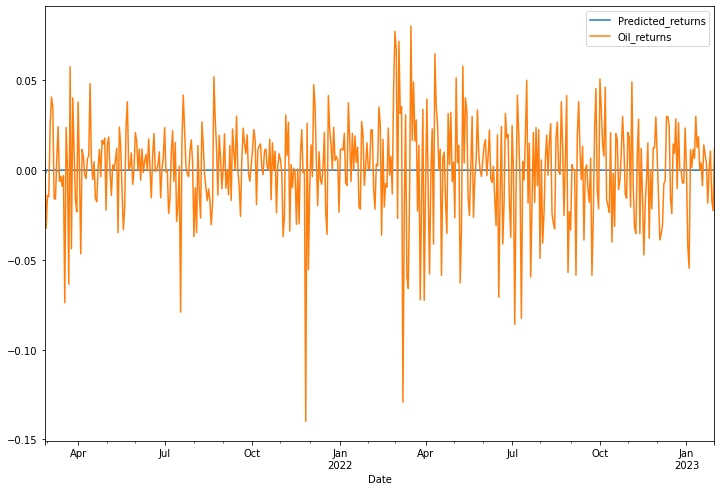

In [952]:

df_arima = pd.read_parquet('oil_best_feats_v3.parquet')
df_arima.set_index('Date', inplace=True)
df_arima = df_arima[['c1']]

df_arima['c1'] = np.log(df_arima.c1) - np.log(df_arima.c1.shift(1))
df_arima.dropna(inplace=True)


df_arima.rename(columns={'c1':'Oil_returns'}, inplace=True)
df_arima.dropna(inplace=True)

ad_fuller_result = adfuller(df_arima['Oil_returns'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
train = df_arima[:-504]
test = df_arima[-504:]

val_int = int(len(train)*0.1)
val = train[-val_int:]
train = train[:-val_int]

import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_arima['Oil_returns'],order=(1, 0, 1),seasonal_order=(1,0,1,12))
results=model.fit()

train['Predicted_returns']= results.predict(start=0, end=8914,dynamic=True)
val['Predicted_returns'] =  results.predict(start=8915, end=9904,dynamic=True)
test['Predicted_returns']=  results.predict(start=9905, end=10408,dynamic=True)
test[['Predicted_returns','Oil_returns']].plot(figsize=(12,8))

rmse_test = math.sqrt(mean_squared_error(test.Oil_returns, test.Predicted_returns))
rmse_train = math.sqrt(mean_squared_error(train.Oil_returns, train.Predicted_returns))
rmse_val = math.sqrt(mean_squared_error(val.Oil_returns, val.Predicted_returns))

print('RMSE: '+str(rmse_test))
print('RMSE: '+str(rmse_train))
print('RMSE: '+str(rmse_val))


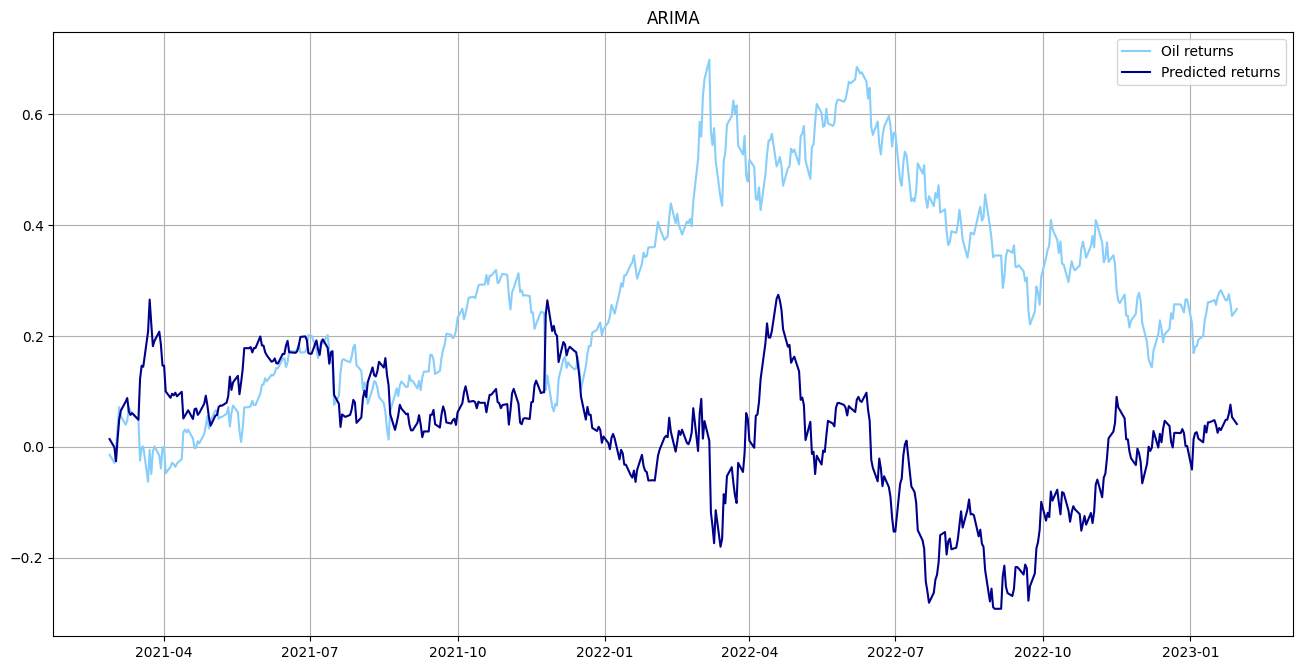

In [953]:
# ARIMA

test.dropna(inplace=True)

test['Oil_returns'] = test['Oil_returns'].shift(-1)
test['Predicted_returns'] = test['Predicted_returns'].shift(-1)

test['Signal_predicted'] = np.where(test['Predicted_returns'] > test['Predicted_returns'].shift(-1), 1, -1)
test['Signal_real'] = np.where(test['Oil_returns'] > test['Oil_returns'].shift(-1),1, -1)


test['Strategy_returns'] = test['Signal_predicted'].shift(1) * test['Oil_returns']    

test.dropna(inplace=True)



test['Cumulative_real'] = test['Oil_returns'].cumsum()
test['Cumulative_strategy'] = test['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('ARIMA')
plt.legend(loc='best')

In [954]:
test1 = sharpe_ratio(test, 'Cumulative_strategy', 504, 0.001)
test1['Avg_daily_returns'] = test1['Strategy_returns'].mean()
test1['St_dev_of_return'] = test1['Strategy_returns'].std()

In [912]:
# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')


momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])

In [913]:
test.reset_index(inplace=True)
test['Date'] = pd.to_datetime(test['Date'])
test_zero = pd.merge(test, ff_regression_df, on='Date', how='left')
test_zero.dropna(inplace=True)

In [914]:
# Regression on market factors
y = test_zero[['Strategy_returns']]
X = test_zero[['Mkt-RF','SMB', 'HML', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]
X = X.rename(columns={'Oil_returns':'Oil_returns'})

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_zero_ret = model.fit() 
test_df_zero_ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.394
Date:                Mon, 22 May 2023   Prob (F-statistic):              0.206
Time:                        10:54:30   Log-Likelihood:                 1092.9
No. Observations:                 485   AIC:                            -2170.
Df Residuals:                     477   BIC:                            -2136.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.001     -0.284      0.777      -0.003       0.002
Mkt-RF          0.0007      0.001      0.650      0.516      -0.001       0.003
SMB            -0.0011      0.002     -0.558      0.577      -0.005       0.003
HML             0.0051      0.002      2.062      0.040       0.000       0.010
Mom          1.022e-05      0.001      0.009      0.993      -0.002       0.002
LT_Rev         -0.0047      0.003     -1.618      0.106      -0.010       0.001
ST_Rev          0.0011      0.001      0.878      0.380      -0.001       0.003
Oil_returns     0.0693      0.046      1.505      0.133      -0.021       0.160
==============================================================================
Omnibus:                       23.952   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.657
Skew:                          -0.191   Prob(JB):                     1.83e-13
Kurtosis:                       4.661   Cond. No.                         78.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [915]:
# Momentum strategy
window = 30
momentum_df = pd.read_parquet('oil_best_feats_v3.parquet')
momentum_df.set_index('Date', inplace=True)
momentum_df = momentum_df[['c1']] 
momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['Oil_returns'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Oil_momentum'] = momentum_df.Position_real_mom.shift(1) * momentum_df["Oil_returns"]
momentum_df = momentum_df[-test.shape[0]:]

In [916]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)
carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test.shape[0]:]

In [917]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Oil_carry'] = strategies_df["Oil_returns"] * strategies_df["carry"]
# Regression on both of strategies
test.reset_index(inplace=True, drop=True)
y = test[['Strategy_returns']]
X = strategies_df[['Oil_returns', 'Oil_carry', 'Oil_momentum']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_zero_ret_mom = model.fit() 
test_df_zero_ret_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.723
Date:                Mon, 22 May 2023   Prob (F-statistic):              0.161
Time:                        10:54:32   Log-Likelihood:                 1111.4
No. Observations:                 502   AIC:                            -2215.
Df Residuals:                     498   BIC:                            -2198.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.001      0.112      0.911      -0.002       0.002
Oil_returns     -0.0178      0.045     -0.399      0.690      -0.105       0.070
Oil_carry        0.0262      0.045      0.588      0.557      -0.061       0.114
Oil_momentum     0.0961      0.045      2.155      0.032       0.008       0.184
==============================================================================
Omnibus:                       29.279   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.035
Skew:                          -0.005   Prob(JB):                     3.12e-22
Kurtosis:                       5.176   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# ZERO RETURNS

In [957]:
# zero returns
df_zero_ret = pd.read_parquet('oil_best_feats_v3.parquet')
df_zero_ret.set_index('Date', inplace=True)

df_zero_ret = df_zero_ret[['c1']]

df_zero_ret['c1'] = np.log(df_zero_ret.c1) - np.log(df_zero_ret.c1.shift(1))
df_zero_ret.rename(columns={'c1':'Oil_returns'}, inplace=True)
df_zero_ret.dropna(inplace=True)
df_zero_ret['Predicted_returns'] = 0


train = df_zero_ret[:-504]
test = df_zero_ret[-504:]

val_int = int(len(train)*0.1)
val = train[-val_int:]


rmse_train = math.sqrt(mean_squared_error(train.Oil_returns, train.Predicted_returns))
rmse_val = math.sqrt(mean_squared_error(val.Oil_returns, val.Predicted_returns))
rmse_test = math.sqrt(mean_squared_error(test.Oil_returns, test.Predicted_returns))
print('RMSE: '+str(rmse_train))
print('RMSE: '+str(rmse_val))
print('RMSE: '+str(rmse_test))  

RMSE: 0.026652551494531163
RMSE: 0.041090963168330455
RMSE: 0.02656367376312381


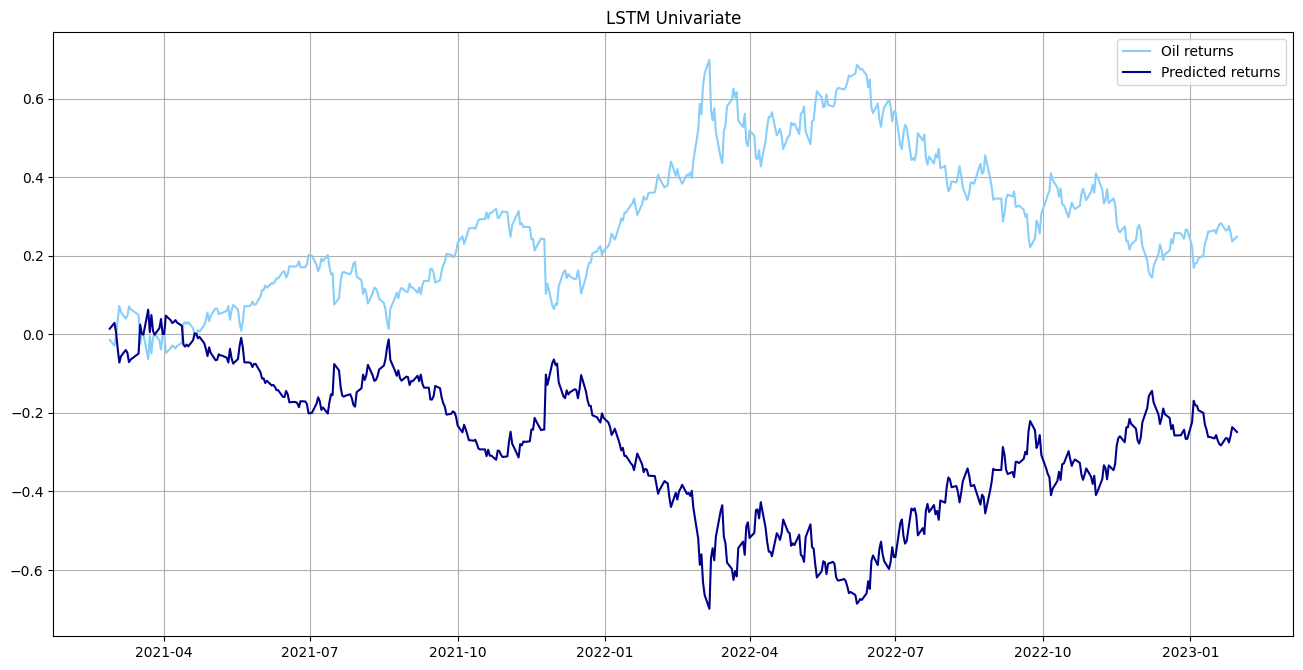

In [958]:
# ZERO Returns strategy

test.dropna(inplace=True)

test['Oil_returns'] = test['Oil_returns'].shift(-1)
test['Predicted_returns'] = test['Predicted_returns'].shift(-1)

test['Signal_predicted'] = np.where(test['Predicted_returns'] > test['Predicted_returns'].shift(-1), 1, -1)
test['Signal_real'] = np.where(test['Oil_returns'] > test['Oil_returns'].shift(-1),1, -1)


test['Strategy_returns'] = test['Signal_predicted'].shift(1) * test['Oil_returns']    #preds.signal_preds.shift(1) * preds['preds_returns']
#tor['real_returns'] = tor.signal_real * tor.real_returns
test.dropna(inplace=True)


test['Cumulative_real'] = test['Oil_returns'].cumsum()
test['Cumulative_strategy'] = test['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('LSTM Univariate')
plt.legend(loc='best')

In [959]:
test1 = sharpe_ratio(test, 'Cumulative_strategy', 504, 0.001)

test1['Avg_daily_returns'] = test1['Strategy_returns'].mean()
test1['St_dev_of_return'] = test1['Strategy_returns'].std()

In [962]:
# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')


momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])

In [963]:
ff_regression_df.columns

Index(['Date', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom   ', 'LT_Rev', 'ST_Rev'], dtype='object')

In [964]:
test.reset_index(inplace=True)
test['Date'] = pd.to_datetime(test['Date'])
test_zero = pd.merge(test, ff_regression_df, on='Date', how='left')
test_zero.dropna(inplace=True)

In [965]:
# Regression on market factors
y = test_zero[['Strategy_returns']]
X = test_zero[['Mkt-RF' ,'SMB', 'HML', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]
X = X.rename(columns={'Oil_returns':'Oil_returns'})

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_zero_ret = model.fit() 
test_df_zero_ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.129e+29
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        11:08:42   Log-Likelihood:                 16441.
No. Observations:                 485   AIC:                        -3.287e+04
Df Residuals:                     477   BIC:                        -3.283e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.02e-17   2.11e-17     -0.483      0.629   -5.17e-17    3.13e-17
Mkt-RF        5.84e-17      2e-17      2.922      0.004    1.91e-17    9.77e-17
SMB         -4.922e-16   3.72e-17    -13.238      0.000   -5.65e-16   -4.19e-16
HML         -9.091e-16   4.43e-17    -20.518      0.000   -9.96e-16   -8.22e-16
Mom         -1.785e-16   2.07e-17     -8.625      0.000   -2.19e-16   -1.38e-16
LT_Rev       1.105e-15   5.23e-17     21.118      0.000       1e-15    1.21e-15
ST_Rev       3.223e-17   2.22e-17      1.452      0.147   -1.14e-17    7.58e-17
Oil_returns    -1.0000   8.32e-16   -1.2e+15      0.000      -1.000      -1.000
==============================================================================
Omnibus:                        7.357   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.025   Jarque-Bera (JB):               10.914
Skew:                           0.054   Prob(JB):                      0.00427
Kurtosis:                       3.727   Cond. No.                         78.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [966]:
# Momentum strategy
window = 30
momentum_df = pd.read_parquet('oil_best_feats_v3.parquet')
momentum_df.set_index('Date', inplace=True)

momentum_df = momentum_df[['c1']] 
momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['Oil_returns'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Oil_momentum'] = momentum_df.Position_real_mom.shift(1) * momentum_df["Oil_returns"]
momentum_df = momentum_df[-test.shape[0]:]

In [967]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test.shape[0]:]

In [968]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Oil_carry'] = strategies_df["Oil_returns"] * strategies_df["carry"]
# Regression on both of strategies
test.reset_index(inplace=True, drop=True)
y = test[['Strategy_returns']]
X = strategies_df[['Oil_returns', 'Oil_carry', 'Oil_momentum']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_zero_ret_mom = model.fit() 
test_df_zero_ret_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.494e+33
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        11:08:48   Log-Likelihood:                 19275.
No. Observations:                 502   AIC:                        -3.854e+04
Df Residuals:                     498   BIC:                        -3.853e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.143e-19   2.29e-19      0.499      0.618   -3.36e-19    5.64e-19
Oil_returns     -1.0000   8.61e-18  -1.16e+17      0.000      -1.000      -1.000
Oil_carry     1.911e-16   8.61e-18     22.189      0.000    1.74e-16    2.08e-16
Oil_momentum  8.987e-18   8.62e-18      1.043      0.297   -7.94e-18    2.59e-17
==============================================================================
Omnibus:                       67.719   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.627
Skew:                          -0.443   Prob(JB):                     5.38e-76
Kurtosis:                       6.973   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Feature Engineering

In [24]:
df = pd.read_excel("wti_data.xlsx", sheet_name='Close',parse_dates=['Date'])
dates = pd.read_excel("wti_data.xlsx", sheet_name='Maturities', parse_dates = ['NCL_LTD'])
ncl = pd.read_excel("wti_data.xlsx", sheet_name='LTD_ID', parse_dates = ['Date'])
volume = pd.read_excel("wti_data.xlsx", sheet_name='Volume', parse_dates=['Date'])
open = pd.read_excel("wti_data.xlsx", sheet_name='Open', parse_dates=['Date'])
high = pd.read_excel("wti_data.xlsx", sheet_name='High', parse_dates=['Date'])
close = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
low = pd.read_excel("wti_data.xlsx", sheet_name='Low', parse_dates=['Date'])


df.rename(columns={df.columns[1]: 'c1', df.columns[2]:'c2'}, inplace=True)
df = df[['Date','c1', 'c2']]
df['Spread'] = df['c1']-df['c2']
df['Spread'] = df['Spread'].shift(-1)
df = pd.merge(df, dates, left_on='Date', right_on='NCL_LTD', how='left')
df.drop(columns='Contract', inplace=True)
df['NCL_LTD'] = np.where(df['NCL_LTD'].notna(), 1, 0)
df['Shift'] = df['NCL_LTD'].shift(-1)
df.loc[df['Shift']==1, ['c1']] = df['c2']
df['Shift'].fillna(0, inplace=True)
df.drop(columns=['c2'], inplace=True)



# TIME FEATURES
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Quarter'] = df.Date.dt.quarter
df['Day'] = df.Date.dt.day_of_week
df['Week'] = df.Date.dt.weekofyear



# MARKET YIELDS
my_1 = pd.read_csv('my_us_1y.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
my_10 = pd.read_csv('my_us_10y.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})

dot_rem(my_1, 'DGS1')
dot_rem(my_10, 'DGS10')

my_1['DGS1'] = my_1['DGS1'].shift(-1)
my_10['DGS10'] = my_10['DGS10'].shift(-1)

df = pd.merge(df, my_1, on='Date', how='left')
df = pd.merge(df, my_10, on='Date', how='left')


# VIX 
vix = pd.read_csv('vix.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
dot_rem(vix, 'VIXCLS')
vix['VIXCLS'] = vix['VIXCLS'].shift(-1)
df = pd.merge(df, vix, on='Date', how='left')


#OIL INVENTORIES
oi = pd.read_csv('oil_inventories_investing.csv', parse_dates=['Release Date']).rename(columns={'Release Date':'Date', 'Actual':'Inventories'})
oi.Date = oi.Date.str.replace(r"\(.*\)","")
oi.Inventories = oi.Inventories.str.replace('(M)', '', regex=True)
oi.Date = pd.to_datetime(oi.Date)
oi.Inventories = oi.Inventories.astype('float')
oi.Inventories = oi.Inventories*1000000
oi = oi[['Date', 'Inventories']]

oi_2008 = oi[oi.Date<='2008-01-01']
oi_2008.index = pd.to_datetime(oi_2008.Date)
oi_2008 = oi_2008.shift(-1, freq = "M")
oi_2008.drop(columns='Date', inplace=True)
oi_2008.reset_index(inplace=True)
oi_2008['Year'] = oi_2008['Date'].dt.year
oi_2008['Month'] = oi_2008['Date'].dt.month
oi_2008.drop(columns='Date', inplace=True)
oi_2008['Inventories'] = oi_2008['Inventories'].shift(-1)

df = pd.merge(df, oi_2008, on=['Month', 'Year'], how='left')

oi_22 = oi[oi.Date>'2008-01-01']
oi_22['Year'] = oi_22['Date'].dt.year
oi_22['Week'] = oi_22['Date'].dt.weekofyear
oi_22.drop(columns='Date', inplace=True)
oi_22['Inventories'] = oi_22['Inventories'].shift(-1)

df = pd.merge(df, oi_22, on=['Week', 'Year'], how='left')
df.Inventories_x.fillna(0, inplace=True)  
df.Inventories_y.fillna(0, inplace=True)  
df['Inventories']=df['Inventories_x'] + df['Inventories_y']

df.drop(columns=['Inventories_x','Inventories_y'], inplace=True)
df.drop_duplicates(subset=['Date'], inplace=True)


#RIG COUNT
rig = pd.read_csv('rig.csv', parse_dates=['Release Date']).rename(columns={'Release Date':'Date', 'Actual':'Rig_actual'})
rig = rig[['Date', 'Rig_actual']].dropna()
rig['Week'] = rig['Date'].dt.weekofyear
rig['Month'] = rig['Date'].dt.month
rig['Year'] = rig['Date'].dt.year
rig.drop(columns='Date', inplace=True)
rig['Rig_actual'] = rig['Rig_actual'].shift(-1)

df = pd.merge(df, rig, on=['Week', 'Month', 'Year'], how='left')
df.drop_duplicates(subset=['Date'], inplace=True)


# US PRODUCTION
us_prod = pd.read_csv('us_ind_prod.csv').rename(columns={'Release Date':'Date', 'Actual':'Prod_actual'})
us_prod.Date = us_prod.Date.str.replace(r"\(.*\)","")
us_prod.Prod_actual = us_prod.Prod_actual.str.replace('(%)', '', regex=True).astype('float')
us_prod.Date = pd.to_datetime(us_prod.Date)
us_prod = us_prod[['Date', 'Prod_actual']]
us_prod['Month'] = us_prod['Date'].dt.month
us_prod['Year'] = us_prod['Date'].dt.year
us_prod.drop(columns='Date', inplace=True)
us_prod.dropna(inplace=True)
us_prod['Prod_actual'] = us_prod['Prod_actual'].shift(-1)

df = pd.merge(df, us_prod, on=['Month', 'Year'], how='left')


#GDP
us_gdp = pd.read_csv('gdp_us.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
us_gdp['Quarter'] = us_gdp.Date.dt.quarter
us_gdp['Year'] = us_gdp.Date.dt.year
us_gdp.drop(columns='Date', inplace=True)
us_gdp['GDP'] = us_gdp['GDP'].shift(-1)

df = pd.merge(df, us_gdp, on=['Quarter', 'Year'], how='left')


#CPI
cpi = pd.read_csv('CPIAUCSL.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
cpi['Month'] = cpi.Date.dt.month
cpi['Year'] = cpi.Date.dt.year
cpi.drop(columns='Date', inplace=True)
cpi['CPIAUCSL'] = cpi['CPIAUCSL'].shift(-1)

df = pd.merge(df, cpi, on=['Month', 'Year'], how='left')


# S&P
sp = y_data_downloader("^GSPC", "1983-01-01", "2023-03-01", "sp")
df = pd.merge(df, sp, on='Date', how='left')


# NASDAQ
ns = y_data_downloader("^IXIC", "1983-01-01", "2023-03-01", "nasdaq")
df = pd.merge(df, ns, on='Date', how='left')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
df.fillna(0, inplace=True)

# Sentiment Analysis

# BERT

In [26]:
finbert =  AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [27]:
# Download the news
nlp = pd.read_csv('nlp_opec_10_22.csv')
lis =[]
for ind in nlp.index:
    dict={}
    try:
      
      article = Article(nlp['link'][ind])
      article.download()
      article.parse()
      article.nlp()

    except:
      
      pass
  
    dict['Date']=nlp['date'][ind]
    dict['Media']=nlp['media'][ind]
    dict['Title']=article.title
    dict['Article']=article.text
    dict['Summary']=article.summary
    dict['Key_words']=article.keywords
    lis.append(dict)

news_df=pd.DataFrame(lis)



In [28]:
def remove_alphanumeric_chars(df, column_to_clean, new_column):
    '''

    Function to remove 
    alphanumeric characters

    '''
    df[new_column] = df[column_to_clean].str.replace('[^A-Za-z0-9]+', ' ')
    df[new_column] = df[new_column].str.lower()

    return df


def fin_sentiment_analyzer_bert(text):

    token =     tokenizer.encode(text, return_tensors='pt')
    sentiment = finbert(token)
    score =     int(torch.argmax(sentiment.logits)) + 1

    return score


news_df = remove_alphanumeric_chars(news_df, 'Article', 'Summary_cleaned')
nlp =     pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

news_df['Sentiment'] =       news_df['Summary_cleaned'].apply(lambda x: nlp(x[:512]))
news_df['Fin_Score'] =       news_df['Summary_cleaned'].apply(lambda x: nlp(x[:512])[0]['score'])
news_df['Sentiment_label'] = news_df['Summary_cleaned'].apply(lambda x: nlp(x[:512])[0]['label'])

In [29]:
news_df.to_csv('nlp_dp.csv')

In [882]:
news_df = pd.read_csv('nlp_dp.csv')

In [883]:
news_df.shape

(1781, 11)

In [31]:
correct_m = {

        'an':'Jan',
        'eb':'Feb',
        'ar':'Mar', 
        'pr':'Apr',
        'ay':'May',
        'un':'Jun',
        'ul':'Jul', 
        'ug':'Aug', 
        'ep':'Sep',
        'ct':'Oct',
        'ov':'Nov',
        'ec':'Dec'
    }

correct_m_2 = {

    'SS':'S',
    'DD':'D',
    'AA':'A',
    'NN':'N',
    'MM':'M',
    'JJ':'J',
    'FF':'F'
}

for char in correct_m.keys():
    
    news_df.Date = news_df.Date.str.replace(char, correct_m[char])


for char in correct_m_2.keys():
    
    news_df.Date = news_df.Date.str.replace(char, correct_m_2[char]) 

news_df = news_df[['Date', 'Fin_Score', 'Sentiment_label']]
news_df = news_df[news_df.Date!='2 weeks ago']

news_df['splt'] = news_df.Date.str.split(' ').str[0]
news_df['splt'] = news_df['splt'].apply(lambda x: x[1:] if len(x)>3 else x)
news_df['Date1'] = news_df['Date'].str.split().str[1:].str.join('')

news_df['Date'] = news_df['splt'] + ' ' + news_df['Date1']
news_df.Date = pd.to_datetime(news_df.Date, format='%b %d,%Y')


news_df.Date = pd.to_datetime(news_df.Date)

news_df['Sentiment_label'] = np.where((news_df['Sentiment_label']=='Negative'), 0, news_df['Sentiment_label'])
news_df['Sentiment_label'] = np.where((news_df['Sentiment_label']=='Neutral'), 1, news_df['Sentiment_label'])
news_df['Sentiment_label'] = np.where((news_df['Sentiment_label']=='Positive'), 2, news_df['Sentiment_label'])


news_df['Week'] = news_df.Date.dt.weekofyear
news_df['Year'] = news_df.Date.dt.year
news_df = news_df.groupby(['Week', 'Year']).agg({'Fin_Score':'max', 'Sentiment_label':'max'}).reset_index()

In [32]:
news_df.shape

(727, 4)

In [33]:
# MERGE TO MAIN DF
df = pd.merge(df, news_df, on=['Week', 'Year'], how='left')
df['Sentiment_present'] = np.where((df['Sentiment_label']==0), 0, 1)

# GOOGLE TRENDS

In [34]:
trends = pd.read_csv('trends_opec.csv')
trends.Date = pd.to_datetime(trends.Date)
trends['Week'] = trends.Date.dt.weekofyear
trends['Year'] = trends.Date.dt.year
trends.drop(columns='Date', inplace=True)
trends.drop_duplicates(inplace=True)
df = pd.merge(df, trends, on=['Week', 'Year'], how='left')

In [35]:
df.fillna(0, inplace=True)

In [36]:
df.to_parquet('oil_best_feats_v3.parquet')

# Create windows

In [994]:
from keras.callbacks import EarlyStopping

In [969]:
# df_multivariate = pd.read_csv('oil_best_feats_v2.csv')
df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate.set_index('Date', inplace=True)

# Create univariate df
df_univariate = df_multivariate[['c1']]
df_univariate['c1'] = np.log(df_univariate.c1) - np.log(df_univariate.c1.shift(1))
df_univariate.dropna(inplace=True)
df_univariate = np.asarray(df_univariate)

# create univariate windows
train_univariate, test_univariate = df_univariate[:-TEST_SIZE], df_univariate[-TEST_SIZE:]
X_train_univariate, y_train_univariate = create_data_train(train_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)
X_test_univariate, y_test_univariate = create_data_test(test_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)

# LSTM Univariate Time Series Modelling

In [ ]:
# Tuning the hyperparameters of the network

def build_model_lstm_univariate(hp):

  ''''
  Function to optimize the lstm model
  '''
  
  model = Sequential()

  # model.add(LSTM(hp.Int('input_unit' ,min_value=16, max_value=128, step=32), return_sequences=True, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 1)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=16, max_value=128, step=32), return_sequences=True, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


tuner_lstm_univariate = RandomSearch(
        build_model_lstm_univariate,
        objective='mse',
        max_trials=5,
        executions_per_trial=5
        )

tuner_lstm_univariate.search(
        x=X_train_univariate,
        y=y_train_univariate,
        epochs=100,
        batch_size=128,
        
)

best_model_lstm_univariate = tuner_lstm_univariate.get_best_models(num_models=1)[0]
tuner_lstm_univariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)


tuner_lstm_univariate.get_best_hyperparameters()[0].values

best_model_lstm_univariate.summary()





In [ ]:
tuner_lstm_univariate.get_best_hyperparameters()[0].values

In [173]:
# tf.random.set_seed(1234)
lstm_univariate = Sequential()
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=PATIENCE, 
                                    mode='min')
# tf.keras.layers.LeakyReLU(alpha=0.1)
lstm_univariate.add(LSTM(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2]), 
                              return_sequences=False))

# lstm_univariate.add(LSTM(80, activation='relu', input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2]), 
#                               return_sequences=False))


lstm_univariate.add(Dropout(0.01))
lstm_univariate.add(Dense(y_train_univariate.shape[1], activation='tanh'))

optimizer = keras.optimizers.Adam(learning_rate=0.01)

lstm_univariate.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history_lstm_un = lstm_univariate.fit(X_train_univariate ,y_train_univariate,validation_split=VALIDATION_SPLIT ,
                               epochs=100, batch_size=128,
                               callbacks=[early_stopping])

lstm_univariate.evaluate(X_test_univariate, y_test_univariate)
lstm_univariate.evaluate(X_train_univariate, y_train_univariate)

Epoch 1/100


2023-05-20 18:20:36.372258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 4s 45ms/step - loss: 6.9336e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 2/100


2023-05-20 18:20:39.653003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 3s 47ms/step - loss: 6.0470e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 3/100
70/70 [==============================] - 3s 42ms/step - loss: 6.0308e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 4/100
70/70 [==============================] - 3s 49ms/step - loss: 6.0291e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 5/100
70/70 [==============================] - 3s 45ms/step - loss: 6.0252e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 6/100
70/70 [==============================] - 3s 41ms/step - loss: 5.9936e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 7/100
70/70 [==============================] - 3s 39ms/step - loss: 6.0433e-04 - root_mean_squared_error: 0.0246 - val_loss: 0

[0.0007135529885999858, 0.026712412014603615]

In [174]:
lstm_univariate.evaluate(X_test_univariate, y_test_univariate)

16/16 [==============================] - 0s 9ms/step - loss: 7.2907e-04 - root_mean_squared_error: 0.0270


[0.0007290705689229071, 0.027001306414604187]

In [175]:
lstm_univariate.evaluate(X_train_univariate, y_train_univariate)

310/310 [==============================] - 3s 9ms/step - loss: 7.1355e-04 - root_mean_squared_error: 0.0267


[0.0007135529885999858, 0.026712412014603615]

In [ ]:
# save model
pickle.dump(lstm_univariate, open('lstm_univariate1.pkl', 'wb'))

In [ ]:
# Read model
lstm_univariate = pickle.load(open('lstm_univariate.pkl', 'rb'))

310/310 [==============================] - 3s 8ms/step


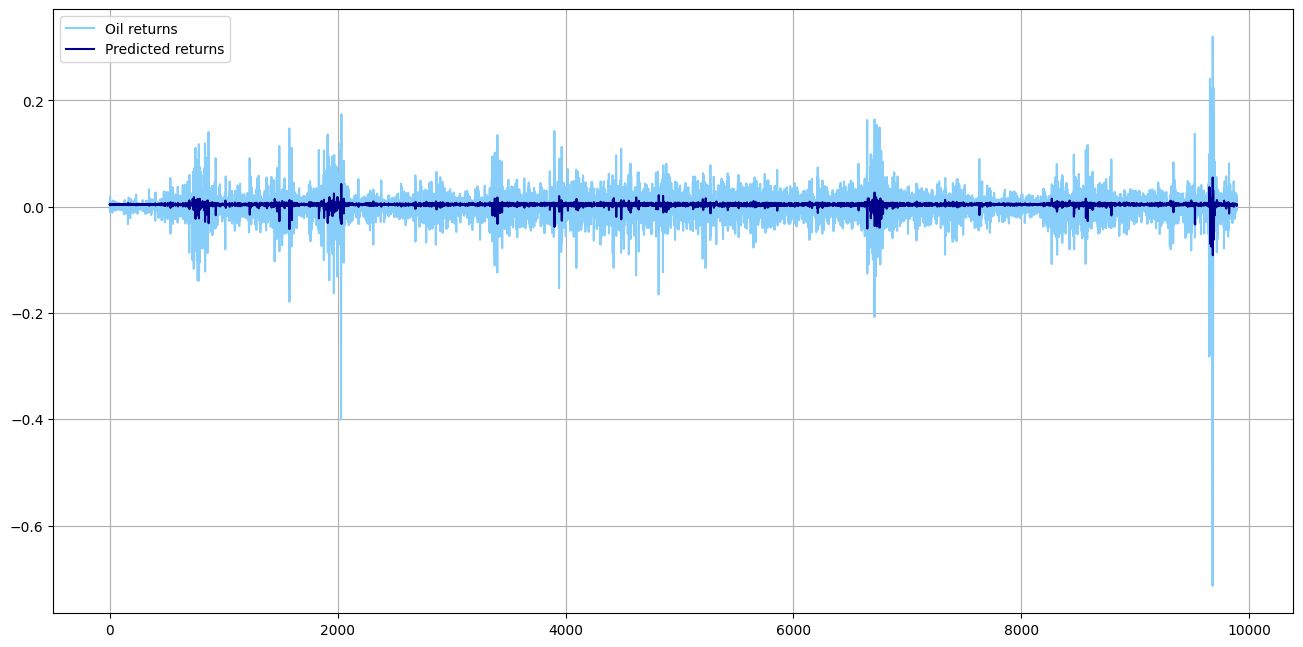

In [970]:
# train data
train_df_lstm_univariate = pd.DataFrame()
y_pred_train = lstm_univariate.predict(X_train_univariate)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train_univariate, (1, y_train_univariate.shape[0]))
train_df_lstm_univariate['Prediction'] = y_pred_train[0].tolist()
train_df_lstm_univariate['Real'] = y_train_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(train_df_lstm_univariate.Real, color='lightskyblue', label='Oil returns')
plt.plot(train_df_lstm_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

16/16 [==============================] - 0s 10ms/step


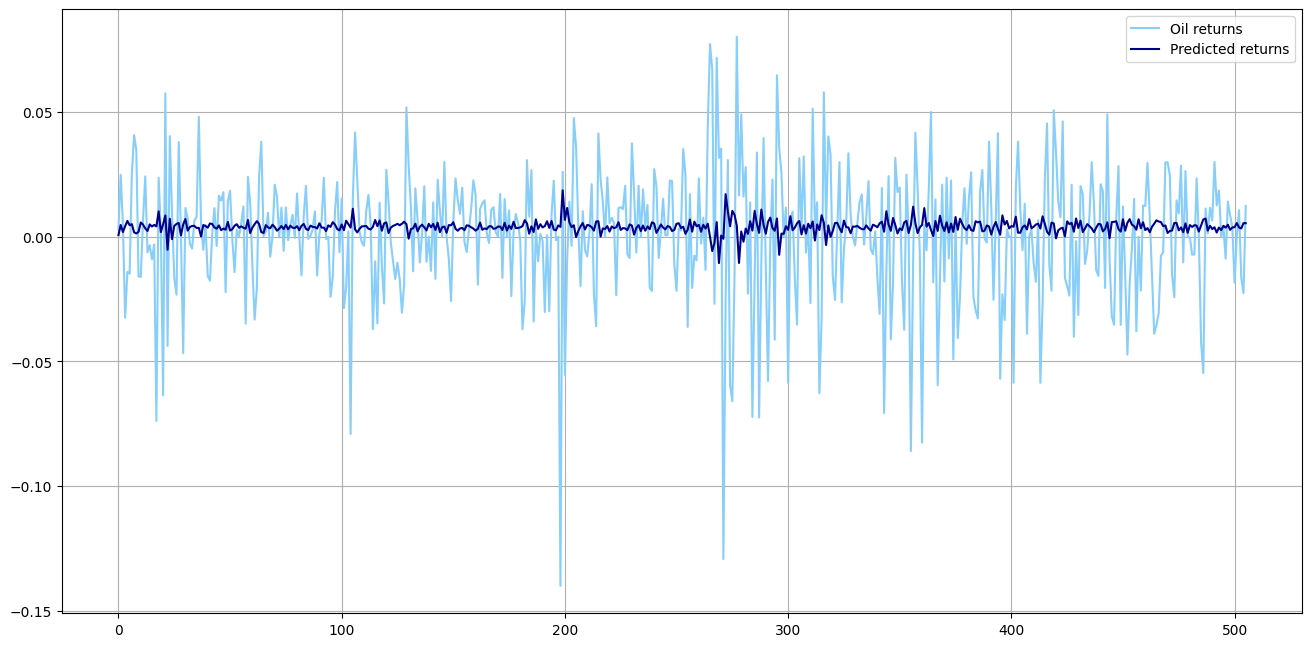

In [971]:
test_df_lstm_univariate = pd.DataFrame()
y_pred_test = lstm_univariate.predict(X_test_univariate)
y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_univariate, (1, y_test_univariate.shape[0]))
test_df_lstm_univariate['Prediction'] = y_pred_test[0].tolist()
test_df_lstm_univariate['Reality'] = y_test_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_univariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

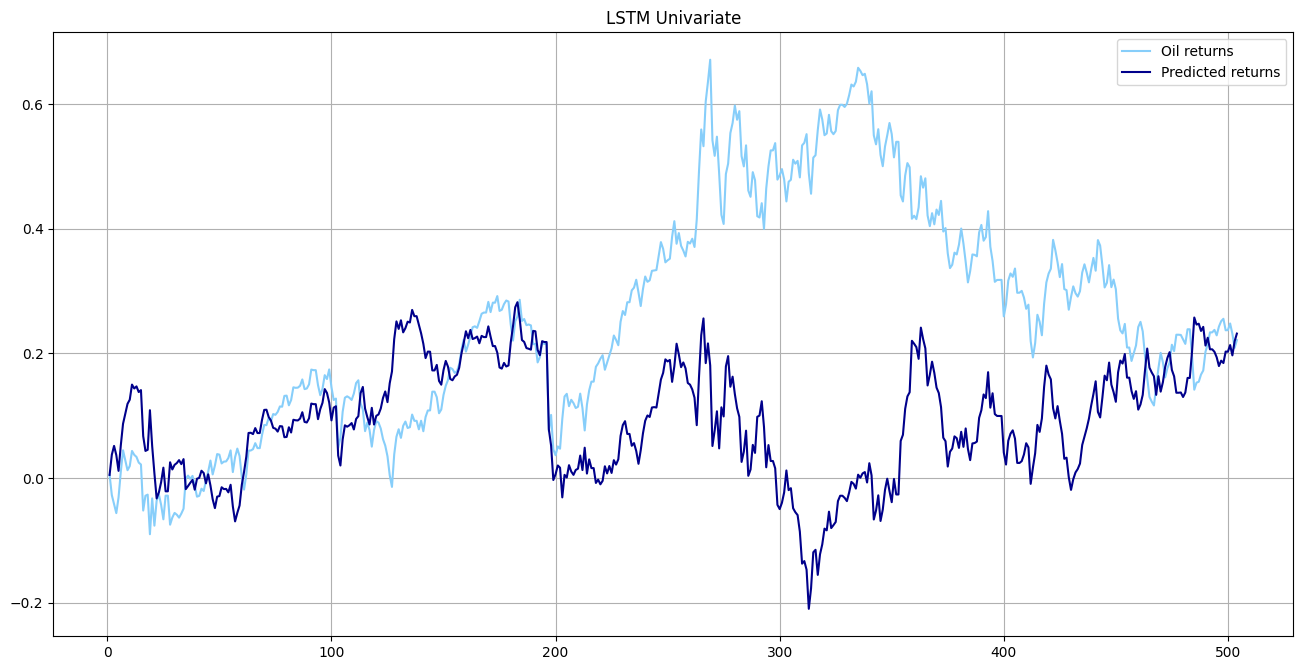

In [972]:



test_df_lstm_univariate.dropna(inplace=True)

test_df_lstm_univariate['Oil_returns'] = test_df_lstm_univariate['Reality'].shift(-1)
test_df_lstm_univariate['Predicted_returns'] = test_df_lstm_univariate['Prediction'].shift(-1)

test_df_lstm_univariate['Signal_predicted'] = np.where(test_df_lstm_univariate['Predicted_returns'] > test_df_lstm_univariate['Predicted_returns'].shift(-1), 1, -1)
test_df_lstm_univariate['Signal_real'] = np.where(test_df_lstm_univariate['Oil_returns'] > test_df_lstm_univariate['Oil_returns'].shift(-1),1, -1)


test_df_lstm_univariate['Strategy_returns'] = test_df_lstm_univariate['Signal_predicted'].shift(1) * test_df_lstm_univariate['Oil_returns']    

test_df_lstm_univariate.dropna(inplace=True)


test_df_lstm_univariate['Cumulative_real'] = test_df_lstm_univariate['Oil_returns'].cumsum()
test_df_lstm_univariate['Cumulative_strategy'] = test_df_lstm_univariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_univariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_univariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('LSTM Univariate')
plt.legend(loc='best')

In [973]:
test_df_lstm_univariate1 = sharpe_ratio(test_df_lstm_univariate, 'Cumulative_strategy', 504, 0.001)

test_df_lstm_univariate1['Avg_daily_returns'] = test_df_lstm_univariate1['Strategy_returns'].mean()
test_df_lstm_univariate1['St_dev_of_return'] = test_df_lstm_univariate1['Strategy_returns'].std()

In [976]:
# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')


momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])


In [977]:
test = df_multivariate[-test_df_lstm_univariate.shape[0]:]
test.reset_index(inplace=True)
test_df_lstm_univariate['Date'] = test['Date']
test_df_lstm_univariate['Date'] = pd.to_datetime(test_df_lstm_univariate['Date'])
test_df_lstm_univariate = pd.merge(test_df_lstm_univariate, ff_regression_df, on='Date', how='left')
test_df_lstm_univariate.dropna(inplace=True)

In [978]:
# Regression on market factors
y = test_df_lstm_univariate[['Strategy_returns']]
X = test_df_lstm_univariate[[ 'Mkt-RF','SMB', 'HML', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]
X = X.rename(columns={'Oil_returns':'Oil_returns'})

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_lstm_univariate_regr = model.fit() 
test_df_lstm_univariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.943
Date:                Mon, 22 May 2023   Prob (F-statistic):           0.000337
Time:                        11:15:31   Log-Likelihood:                 1087.1
No. Observations:                 486   AIC:                            -2158.
Df Residuals:                     478   BIC:                            -2125.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0007      0.001      0.601      0.548      -0.002       0.003
Mkt-RF          0.0011      0.001      0.974      0.331      -0.001       0.003
SMB            -0.0024      0.002     -1.134      0.257      -0.006       0.002
HML             0.0018      0.002      0.734      0.463      -0.003       0.007
Mom            -0.0004      0.001     -0.319      0.750      -0.003       0.002
LT_Rev       4.604e-05      0.003      0.016      0.988      -0.006       0.006
ST_Rev          0.0022      0.001      1.764      0.078      -0.000       0.005
Oil_returns     0.2021      0.045      4.517      0.000       0.114       0.290
==============================================================================
Omnibus:                       29.027   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.299
Skew:                          -0.211   Prob(JB):                     2.22e-18
Kurtosis:                       4.959   Cond. No.                         74.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [979]:
# Momentum
window = 30
momentum_df =  df_multivariate[['c1']]
momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['Oil_returns'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Oil_momentum'] = momentum_df.Position_real_mom.shift(1) * momentum_df["Oil_returns"]
momentum_df = momentum_df[-test_df_lstm_univariate.shape[0]:]

In [980]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_lstm_univariate.shape[0]:]

In [981]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Oil_carry'] = strategies_df["Oil_returns"] * strategies_df["carry"]
# Regression on both of strategies
test_df_lstm_univariate.reset_index(inplace=True, drop=True)
y = test_df_lstm_univariate[['Strategy_returns']]
X = strategies_df[['Oil_returns', 'Oil_carry', 'Oil_momentum']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_lstm_univariate_regr_mom = model.fit() 

test_df_lstm_univariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8764
Date:                Mon, 22 May 2023   Prob (F-statistic):              0.453
Time:                        11:15:38   Log-Likelihood:                 1074.7
No. Observations:                 486   AIC:                            -2141.
Df Residuals:                     482   BIC:                            -2125.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0010      0.001      0.792      0.429      -0.001       0.003
Oil_returns     -0.0036      0.045     -0.079      0.937      -0.093       0.086
Oil_carry       -0.0297      0.045     -0.653      0.514      -0.119       0.060
Oil_momentum    -0.0664      0.045     -1.461      0.145      -0.156       0.023
==============================================================================
Omnibus:                       70.127   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.196
Skew:                          -0.676   Prob(JB):                     6.18e-46
Kurtosis:                       5.907   Cond. No.                         38.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# CNN Univariate Time Series Modelling

In [ ]:
tf.random.set_seed(1234)

In [826]:
df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate.set_index('Date', inplace=True)

# Create univariate df
df_univariate = df_multivariate[['c1']]
df_univariate['c1'] = np.log(df_univariate.c1) - np.log(df_univariate.c1.shift(1))
df_univariate.dropna(inplace=True)
df_univariate = np.asarray(df_univariate)

# create univariate windows
train_univariate, test_univariate = df_univariate[:-TEST_SIZE], df_univariate[-TEST_SIZE:]
X_train_univariate, y_train_univariate = create_data_train(train_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)
X_test_univariate, y_test_univariate = create_data_test(test_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)

In [ ]:
def build_model_cnn_univariate(hp):

  '''
  Function to optimize cnn model
  '''
   
  model = keras.models.Sequential()
  
  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=128,
                              step=32), kernel_size = 2, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=2))

 
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


tuner_cnn_univariate = RandomSearch(
        build_model_cnn_univariate,
        objective='mse',
        max_trials=5,
        executions_per_trial=5
        )

tuner_cnn_univariate.search(
        x=X_train_univariate,
        y=y_train_univariate,
        epochs=100,
        batch_size=128,
        
)

best_model_cnn_univariate = tuner_cnn_univariate.get_best_models(num_models=1)[0]
tuner_cnn_univariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)


tuner_cnn_univariate.get_best_hyperparameters()[0].values

best_model_cnn_univariate.summary()

In [ ]:
tuner_cnn_univariate.get_best_hyperparameters()[0].values

In [755]:
# Multivariate CNN
cnn_univariate = Sequential()
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=100,
                                   mode='min')

cnn_univariate.add(Conv1D(filters=32, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.009), input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
cnn_univariate.add(MaxPooling1D(pool_size=2))
cnn_univariate.add(Flatten())
cnn_univariate.add(Dropout(0.1))
cnn_univariate.add(Dense(y_train_univariate.shape[1], activation=tf.keras.layers.LeakyReLU(alpha=0.009)))
cnn_univariate.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history_cnn_univariate = cnn_univariate.fit(X_train_univariate, y_train_univariate, validation_split=VALIDATION_SPLIT, epochs=70, batch_size=BATCH_SIZE, callbacks=[early_stopping])

cnn_univariate.evaluate(X_test_univariate, y_test_univariate)
cnn_univariate.evaluate(X_train_univariate, y_train_univariate)


Epoch 1/70


2023-05-21 09:31:46.622613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 11ms/step - loss: 6.0378e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 2/70
 1/70 [..............................] - ETA: 0s - loss: 5.8180e-04 - root_mean_squared_error: 0.0241

2023-05-21 09:31:47.485607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 8ms/step - loss: 6.0261e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 3/70
70/70 [==============================] - 1s 7ms/step - loss: 6.0206e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 4/70
70/70 [==============================] - 0s 7ms/step - loss: 6.0263e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 5/70
70/70 [==============================] - 0s 6ms/step - loss: 6.0197e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 6/70
70/70 [==============================] - 0s 7ms/step - loss: 6.0215e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 7/70
70/70 [==============================] - 0s 7ms/step - loss: 6.0188e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val

[0.0006931817042641342, 0.026328343898057938]

In [756]:
cnn_univariate.evaluate(X_test_univariate, y_test_univariate)

16/16 [==============================] - 0s 3ms/step - loss: 7.1008e-04 - root_mean_squared_error: 0.0266


[0.0007100783986970782, 0.02664729580283165]

In [757]:
cnn_univariate.evaluate(X_train_univariate, y_train_univariate)

310/310 [==============================] - 1s 3ms/step - loss: 6.9318e-04 - root_mean_squared_error: 0.0263


[0.0006931817042641342, 0.026328343898057938]

In [ ]:
# save model
pickle.dump(cnn_univariate, open('cnn_univariate.pkl', 'wb'))

In [ ]:
cnn_univariate = pickle.load(open('cnn_univariate.pkl', 'rb'))

310/310 [==============================] - 0s 2ms/step


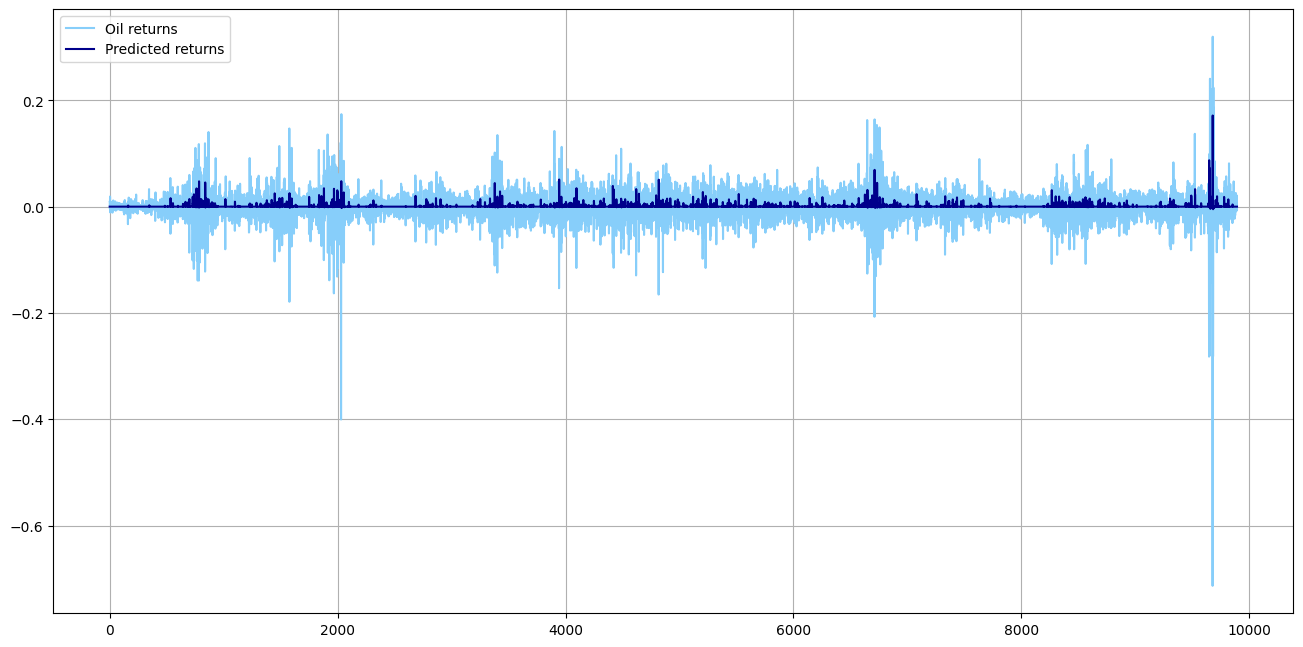

In [982]:
# train data
train_df_cnn_univariate = pd.DataFrame()
y_pred_train = cnn_univariate.predict(X_train_univariate)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train_univariate, (1, y_train_univariate.shape[0]))
train_df_cnn_univariate['Prediction'] = y_pred_train[0].tolist()
train_df_cnn_univariate['Real'] = y_train_real[0].tolist()



plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(train_df_cnn_univariate.Real, color='lightskyblue', label='Oil returns')
plt.plot(train_df_cnn_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

16/16 [==============================] - 0s 3ms/step


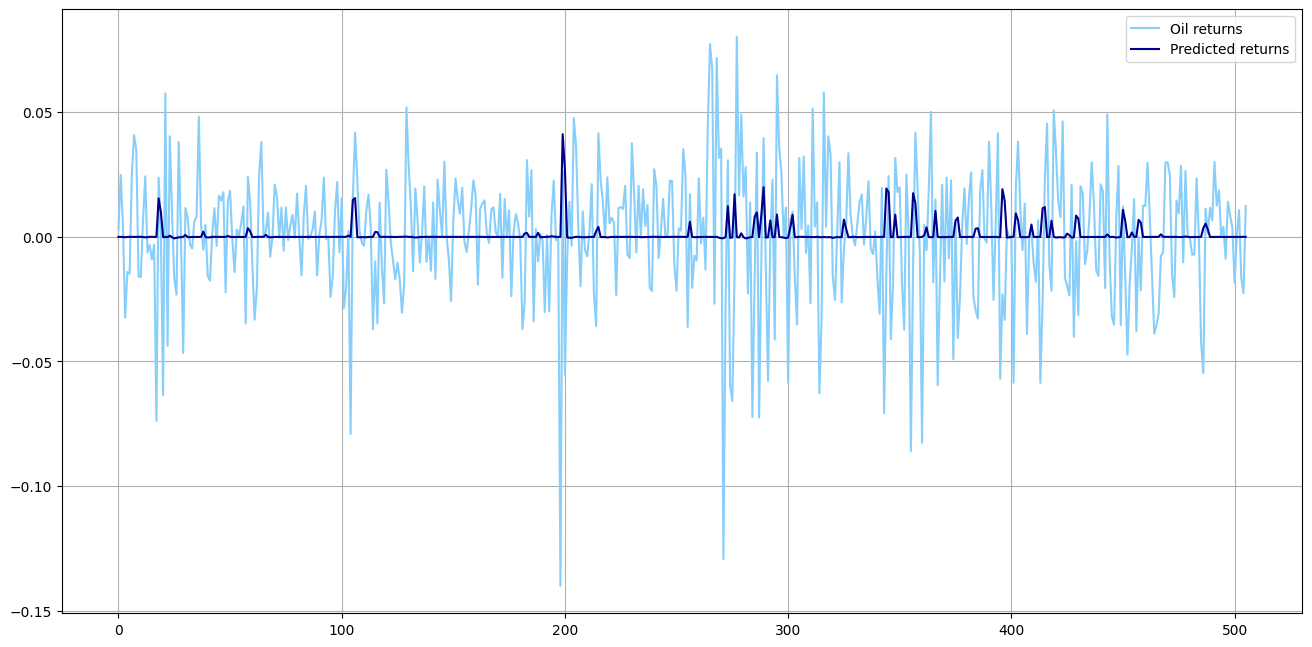

In [983]:
test_df_cnn_univariate = pd.DataFrame()
y_pred_test = cnn_univariate.predict(X_test_univariate)
y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_univariate, (1, y_test_univariate.shape[0]))
test_df_cnn_univariate['Prediction'] = y_pred_test[0].tolist()
test_df_cnn_univariate['Reality'] = y_test_real[0].tolist()




plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_univariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

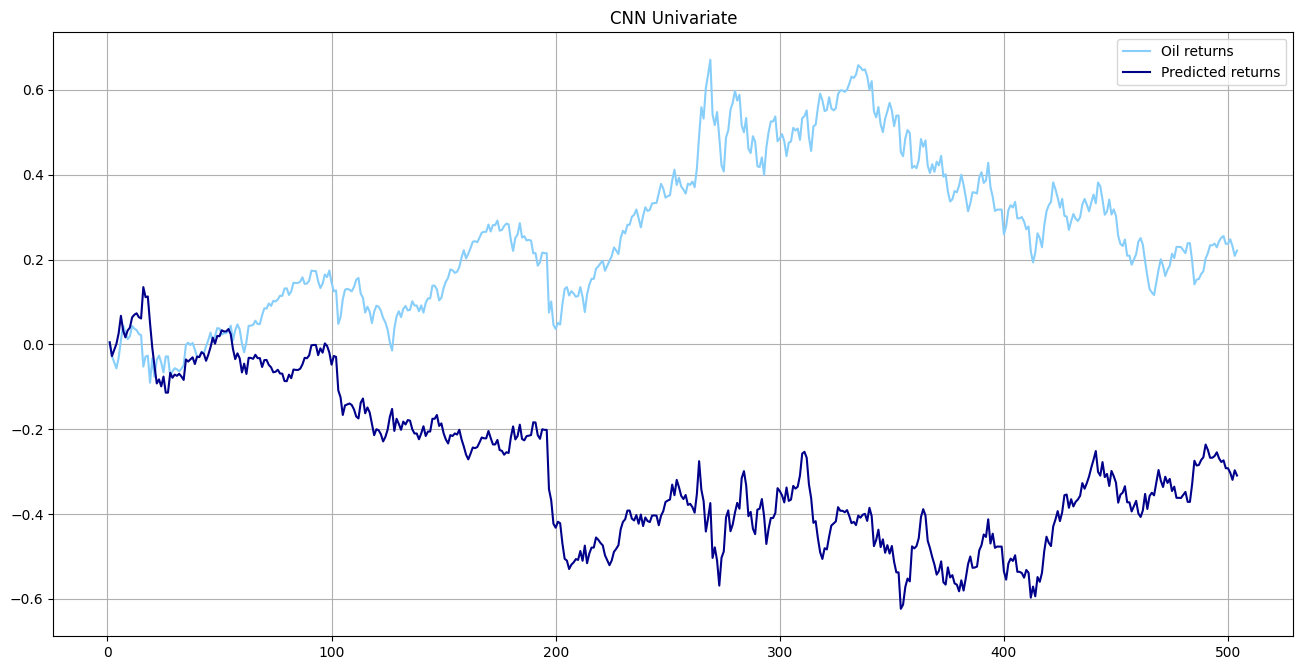

In [984]:
test_df_cnn_univariate.dropna(inplace=True)

test_df_cnn_univariate['Oil_returns'] = test_df_cnn_univariate['Reality'].shift(-1)
test_df_cnn_univariate['Predicted_returns'] = test_df_cnn_univariate['Prediction'].shift(-1)

test_df_cnn_univariate['Signal_predicted'] = np.where(test_df_cnn_univariate['Predicted_returns'] > test_df_cnn_univariate['Predicted_returns'].shift(-1), 1, -1)
test_df_cnn_univariate['Signal_real'] = np.where(test_df_cnn_univariate['Oil_returns'] > test_df_cnn_univariate['Oil_returns'].shift(-1),1, -1)


test_df_cnn_univariate['Strategy_returns'] = test_df_cnn_univariate['Signal_predicted'].shift(1) * test_df_cnn_univariate['Oil_returns']    
test_df_cnn_univariate.dropna(inplace=True)


test_df_cnn_univariate['Cumulative_real'] = test_df_cnn_univariate['Oil_returns'].cumsum()
test_df_cnn_univariate['Cumulative_strategy'] = test_df_cnn_univariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_univariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_univariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('CNN Univariate')
plt.legend(loc='best')

In [985]:
test_df_cnn_univariate1 = sharpe_ratio(test_df_cnn_univariate, 'Cumulative_strategy', 504, 0.001)
test_df_cnn_univariate1['Avg_daily_returns'] = test_df_cnn_univariate1['Strategy_returns'].mean()
test_df_cnn_univariate1['St_dev_of_return'] = test_df_cnn_univariate1['Strategy_returns'].std()

In [988]:

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')

ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])


In [989]:
test = df_multivariate[-test_df_cnn_univariate.shape[0]:]
test.reset_index(inplace=True)
test_df_cnn_univariate['Date'] = test['Date']
test_df_cnn_univariate['Date'] = pd.to_datetime(test_df_cnn_univariate['Date'])
test_df_cnn_univariate = pd.merge(test_df_cnn_univariate, ff_regression_df, on='Date', how='left')
test_df_cnn_univariate.dropna(inplace=True)

In [990]:
# Regression on market factors
y = test_df_cnn_univariate[['Strategy_returns']]

X = test_df_cnn_univariate[[ 'Mkt-RF','SMB', 'HML', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_cnn_multivariate_regr = model.fit() 

test_df_cnn_multivariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.329
Date:                Mon, 22 May 2023   Prob (F-statistic):             0.0241
Time:                        11:20:08   Log-Likelihood:                 1081.2
No. Observations:                 486   AIC:                            -2146.
Df Residuals:                     478   BIC:                            -2113.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0002      0.001     -0.190      0.849      -0.003       0.002
Mkt-RF         -0.0012      0.001     -1.072      0.284      -0.003       0.001
SMB             0.0012      0.002      0.569      0.569      -0.003       0.005
HML             0.0019      0.003      0.753      0.452      -0.003       0.007
Mom            -0.0011      0.001     -0.946      0.344      -0.003       0.001
LT_Rev         -0.0017      0.003     -0.579      0.563      -0.008       0.004
ST_Rev          0.0016      0.001      1.265      0.207      -0.001       0.004
Oil_returns     0.1542      0.045      3.405      0.001       0.065       0.243
==============================================================================
Omnibus:                       28.605   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.347
Skew:                          -0.273   Prob(JB):                     8.74e-16
Kurtosis:                       4.768   Cond. No.                         74.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [836]:
# Momentum strategy
window = 30
momentum_df =  df_multivariate[['c1']]
momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['Oil_returns'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["Oil_returns"]
momentum_df = momentum_df[-test_df_cnn_univariate.shape[0]:]


In [837]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_cnn_univariate.shape[0]:]




In [838]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["Oil_returns"] * strategies_df["carry"]
# Regression on both of strategies

test_df_cnn_univariate.reset_index(inplace=True, drop=True)
y = test_df_cnn_univariate[['Strategy_returns']]
X = strategies_df[['Oil_returns', 'Strat_real_carry', 'Strat_real_mom']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)
test_df_cnn_multivariate_regr_mom = model.fit() 
test_df_cnn_multivariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.812
Date:                Sun, 21 May 2023   Prob (F-statistic):             0.0101
Time:                        19:46:25   Log-Likelihood:                 1078.8
No. Observations:                 486   AIC:                            -2150.
Df Residuals:                     482   BIC:                            -2133.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0002      0.001     -0.194      0.846      -0.003       0.002
Oil_returns         -0.0113      0.045     -0.251      0.802      -0.100       0.077
Strat_real_carry    -0.0747      0.045     -1.658      0.098      -0.163       0.014
Strat_real_mom      -0.1300      0.045     -2.884      0.004      -0.219      -0.041
==============================================================================
Omnibus:                       71.446   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.737
Skew:                          -0.709   Prob(JB):                     4.24e-44
Kurtosis:                       5.802   Cond. No.                         38.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# LSTM Multivariate Time Series Modelling

In [1278]:
# tf.random.set_seed(1234)
df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate['c1'] = np.log(df_multivariate.c1) - np.log(df_multivariate.c1.shift(1))
df_multivariate.dropna(inplace=True)
df_multivariate.set_index('Date', inplace=True)

train = df_multivariate[:-TEST_SIZE]
test = df_multivariate[-TEST_SIZE:]

scaler1 = MinMaxScaler(feature_range=(0,1))
scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# I could do: split train test, 

X_train, y_train = [], []
for i in range(len(train) - WINDOW_SIZE):
    row = [r for r in train[i:i+WINDOW_SIZE]]
    X_train.append(row)
    label = train[i+WINDOW_SIZE][0]
    y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = [], []
for i in range(len(test) - WINDOW_SIZE):
    row = [r for r in test[i:i+WINDOW_SIZE]]
    X_test.append(row)
    label = test[i+WINDOW_SIZE][0]
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
# Tuning the hyperparameters of the network

def build_model_lstm_multivariate(hp):

  ''''
  Function to optimize the lstm model
  '''
  
  model = Sequential()

  # model.add(LSTM(hp.Int('input_unit' ,min_value=16, max_value=128, step=32), return_sequences=True, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 2)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=16, max_value=256, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


tuner_lstm_multivariate = RandomSearch(
        build_model_lstm_multivariate,
        objective='mse',
        max_trials=5,
        executions_per_trial=5
)

tuner_lstm_multivariate.search(
        x=X_train,
        y=y_train,
        epochs=100,
        batch_size=128,
)

best_model_lstm_multivariate = tuner_lstm_multivariate.get_best_models(num_models=1)[0]
tuner_lstm_multivariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)

tuner_lstm_multivariate.get_best_hyperparameters()[0].values

best_model_lstm_multivariate.summary()


In [ ]:
tuner_lstm_multivariate.get_best_hyperparameters()[0].values

In [1279]:

lstm_multivariate = Sequential()

early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   mode='min')
lstm_multivariate.add(LSTM(208, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=True))
lstm_multivariate.add(LSTM(16, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=False))

lstm_multivariate.add(Dropout(0.21)) 
lstm_multivariate.add(Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
lstm_multivariate.compile(optimizer='adam' ,loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
lstm_multivariate.summary()
# fit model
history_lstm_multivariate = lstm_multivariate.fit(X_train, y_train, validation_split = VALIDATION_SPLIT,
                              epochs=100, batch_size=BATCH_SIZE, callbacks=early_stopping)
lstm_multivariate.evaluate(X_test, y_test)
lstm_multivariate.evaluate(X_train, y_train)

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 5, 208)            193024    
                                                                 
 lstm_75 (LSTM)              (None, 16)                14400     
                                                                 
 dropout_53 (Dropout)        (None, 16)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 207,441
Trainable params: 207,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-05-22 17:37:36.447607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 0.0544 - root_mean_squared_error: 0.2332

2023-05-22 17:37:45.325535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 11s 119ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 2/100
70/70 [==============================] - 7s 93ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/100
70/70 [==============================] - 7s 93ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 4/100
70/70 [==============================] - 7s 95ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 5/100
70/70 [==============================] - 7s 102ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 6/100
70/70 [==============================] - 7s 95ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0016 - val_root_mean

[0.0006866371841169894, 0.026203764602541924]

In [1280]:
lstm_multivariate.evaluate(X_test, y_test)

16/16 [==============================] - 0s 22ms/step - loss: 6.6970e-04 - root_mean_squared_error: 0.0259


[0.0006696985219605267, 0.025878535583615303]

In [1281]:
lstm_multivariate.evaluate(X_train, y_train)

310/310 [==============================] - 5s 15ms/step - loss: 6.8664e-04 - root_mean_squared_error: 0.0262


[0.0006866371841169894, 0.026203764602541924]

In [ ]:
# save model
pickle.dump(lstm_multivariate, open('lstm_multivariate.pkl', 'wb'))

In [ ]:
lstm_multivariate = pickle.load(open('lstm_multivariate.pkl', 'rb'))

2023-05-22 17:43:02.759552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


310/310 [==============================] - 4s 13ms/step


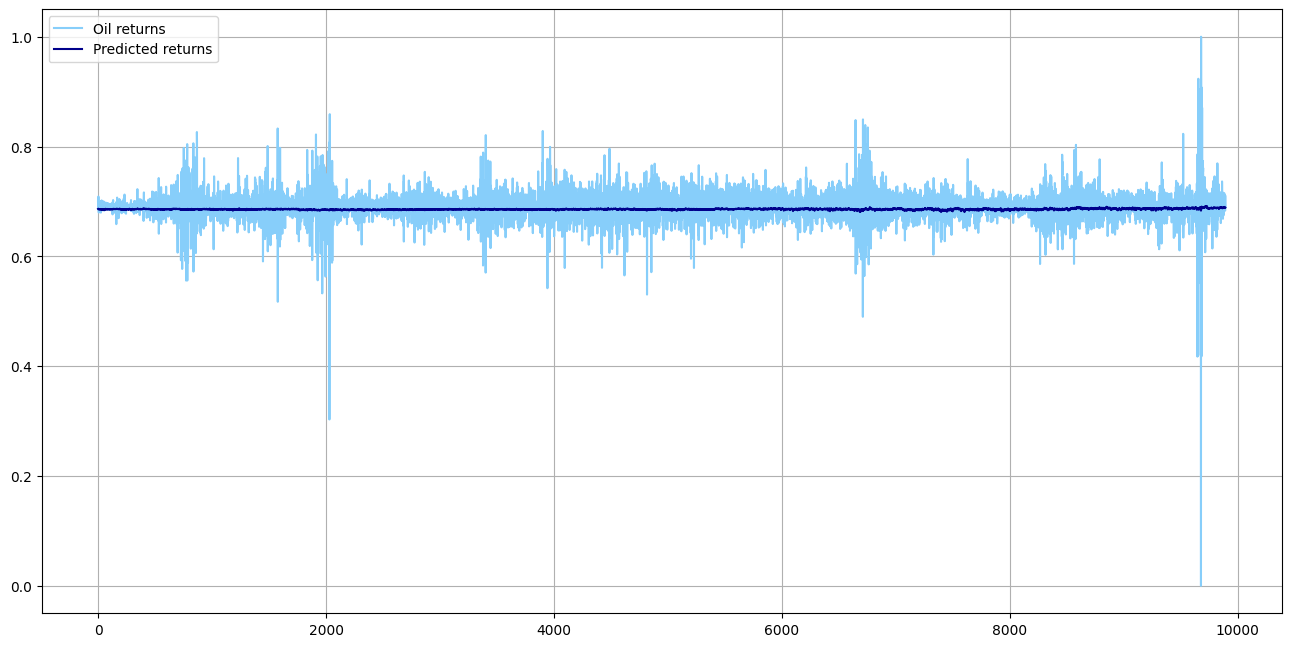

In [1282]:
test_df_lstm_multivariate = pd.DataFrame()
y_pred_train = lstm_multivariate.predict(X_train)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train, (1, y_train.shape[0]))
test_df_lstm_multivariate['Prediction'] = y_pred_train[0].tolist()
test_df_lstm_multivariate['Reality'] = y_train_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')


16/16 [==============================] - 0s 28ms/step


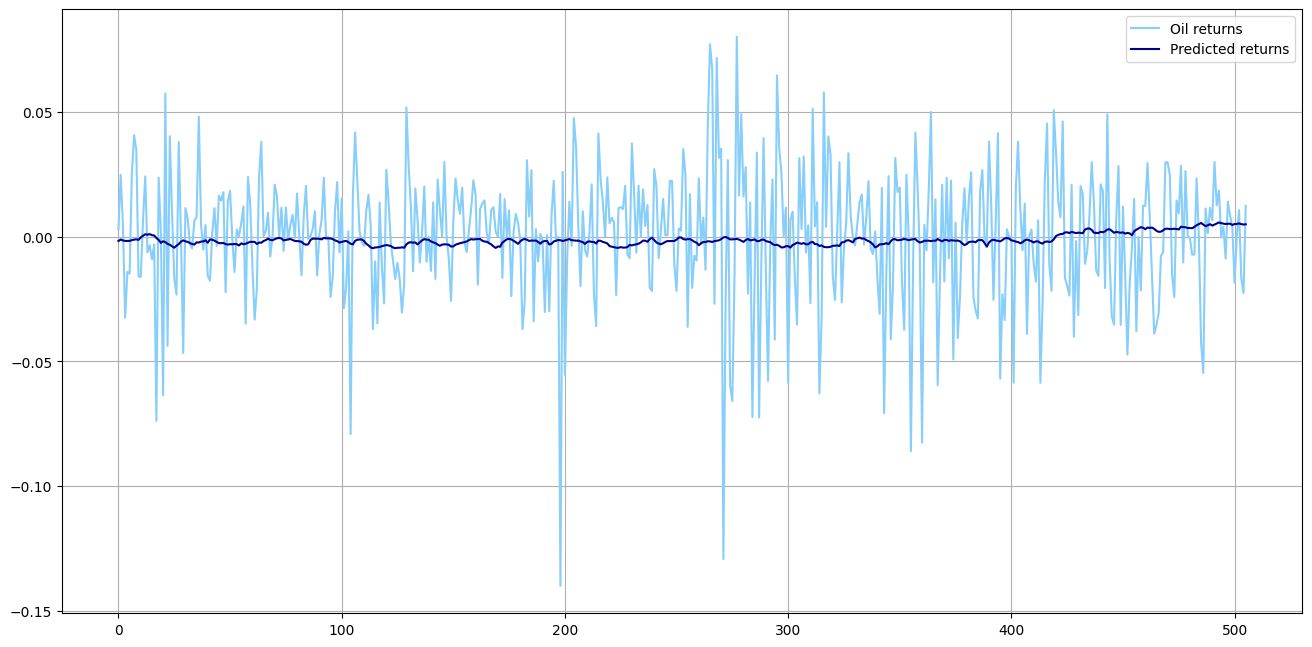

In [1283]:
test_df_lstm_multivariate = pd.DataFrame()
y_pred_test = lstm_multivariate.predict(X_test)
y_pred_test = np.repeat(y_pred_test, train.shape[1], axis=-1)
y_pred_test = scaler.inverse_transform(y_pred_test)[:,0]

y_test_real = y_test.reshape((y_test.shape[0], 1))
y_test_real = np.repeat(y_test_real, train.shape[1], axis=-1)
y_test_real = scaler.inverse_transform(y_test_real)[:,0]

y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_real, (1, y_test_real.shape[0]))
test_df_lstm_multivariate['Prediction'] = y_pred_test[0].tolist()
test_df_lstm_multivariate['Reality'] = y_test_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

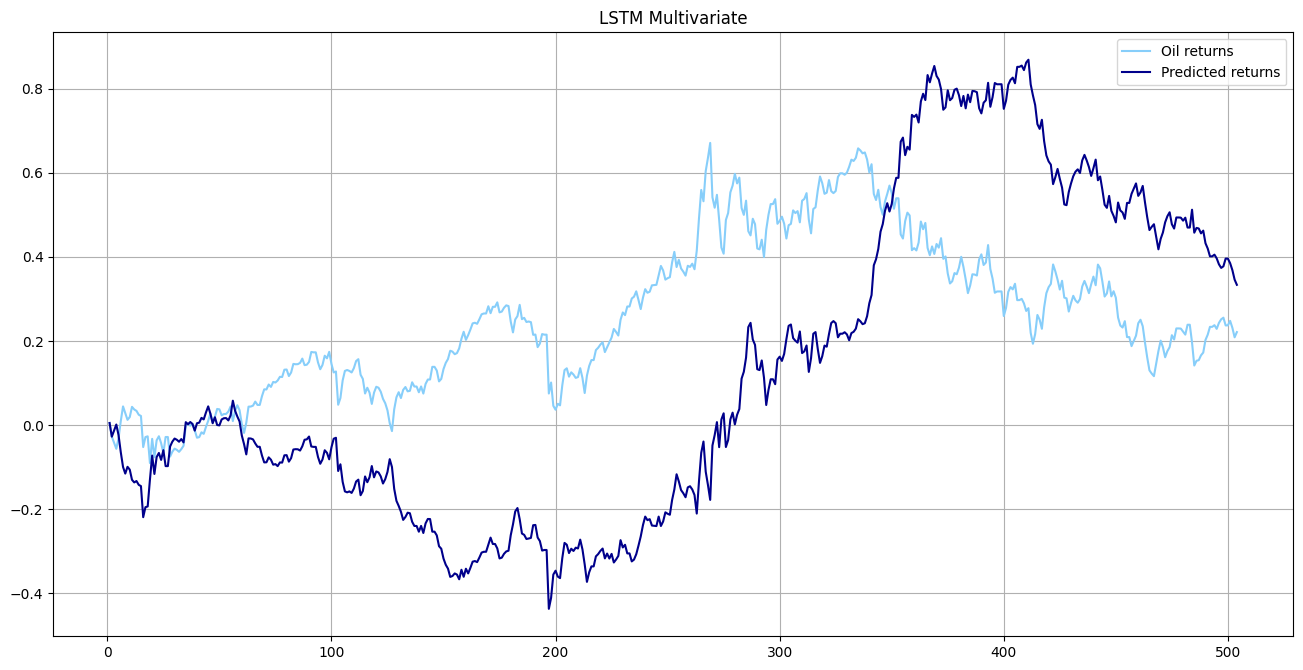

In [1284]:
test_df_lstm_multivariate.dropna(inplace=True)

test_df_lstm_multivariate['Oil_returns'] = test_df_lstm_multivariate['Reality'].shift(-1)
test_df_lstm_multivariate['Predicted_returns'] = test_df_lstm_multivariate['Prediction'].shift(-1)


test_df_lstm_multivariate['Signal_predicted'] = np.where(test_df_lstm_multivariate['Predicted_returns'] > test_df_lstm_multivariate['Predicted_returns'].shift(-1), 1, -1)
test_df_lstm_multivariate['Signal_real'] = np.where(test_df_lstm_multivariate['Oil_returns'] > test_df_lstm_multivariate['Oil_returns'].shift(-1),1, -1)


test_df_lstm_multivariate['Strategy_returns'] = test_df_lstm_multivariate['Signal_predicted'].shift(1) * test_df_lstm_multivariate['Oil_returns'] 

test_df_lstm_multivariate.dropna(inplace=True)


test_df_lstm_multivariate['Cumulative_real'] = test_df_lstm_multivariate['Oil_returns'].cumsum()
test_df_lstm_multivariate['Cumulative_strategy'] = test_df_lstm_multivariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_multivariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_multivariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('LSTM Multivariate')
plt.legend(loc='best')

In [1285]:
#OK
test_df_lstm_multivariate1 = sharpe_ratio(test_df_lstm_multivariate, 'Cumulative_strategy', 504, 0.001)


test_df_lstm_multivariate1['Avg_daily_returns'] = test_df_lstm_multivariate1['Strategy_returns'].mean()
test_df_lstm_multivariate1['St_dev_of_return'] = test_df_lstm_multivariate1['Strategy_returns'].std()

In [1286]:
test_df_lstm_multivariate1.head()

,Prediction,Reality,Oil_returns,Predicted_returns,Signal_predicted,Signal_real,Strategy_returns,Cumulative_real,Cumulative_strategy,sharpe,sharpe_annualized,Avg_daily_returns,St_dev_of_return
1,-0.001099,0.024823,0.004892,-0.001466,1,1,0.004892,0.004892,0.004892,0.343449,0.173098,0.000662,0.026582
2,-0.001466,0.004892,-0.032475,-0.001659,-1,-1,-0.032475,-0.027584,-0.027584,0.343449,0.173098,0.000662,0.026582
3,-0.001659,-0.032475,-0.014082,-0.001657,-1,1,0.014082,-0.041666,-0.013501,0.343449,0.173098,0.000662,0.026582
4,-0.001657,-0.014082,-0.014786,-0.001649,-1,-1,0.014786,-0.056452,0.001284,0.343449,0.173098,0.000662,0.026582
5,-0.001649,-0.014786,0.025284,-0.001341,-1,-1,-0.025284,-0.031167,-0.024000,0.343449,0.173098,0.000662,0.026582


In [1287]:
test_df_lstm_multivariate1.tail()

,Prediction,Reality,Oil_returns,Predicted_returns,Signal_predicted,Signal_real,Strategy_returns,Cumulative_real,Cumulative_strategy,sharpe,sharpe_annualized,Avg_daily_returns,St_dev_of_return
500,0.005119,-0.018424,0.000250,0.005135,-1,-1,-0.000250,0.237279,0.395856,0.343449,0.173098,0.000662,0.026582
501,0.005135,0.000250,0.010673,0.005381,1,1,-0.010673,0.247952,0.385183,0.343449,0.173098,0.000662,0.026582
502,0.005381,0.010673,-0.016554,0.005086,1,1,-0.016554,0.231398,0.368629,0.343449,0.173098,0.000662,0.026582
503,0.005086,-0.016554,-0.022593,0.004922,-1,-1,-0.022593,0.208805,0.346036,0.343449,0.173098,0.000662,0.026582
504,0.004922,-0.022593,0.012375,0.005011,-1,-1,-0.012375,0.221180,0.333661,0.343449,0.173098,0.000662,0.026582


In [1288]:

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])

In [1289]:
test = df_multivariate[-test_df_lstm_multivariate.shape[0]:]
test.reset_index(inplace=True)
test_df_lstm_multivariate['Date'] = test['Date']

test_df_lstm_multivariate['Date'] = pd.to_datetime(test_df_lstm_multivariate['Date'])
test_df_lstm_multivariate = pd.merge(test_df_lstm_multivariate, ff_regression_df, on='Date', how='left')
test_df_lstm_multivariate.dropna(inplace=True)

In [1290]:
# Regression on market factors
y = test_df_lstm_multivariate[['Strategy_returns']]
X = test_df_lstm_multivariate[[ 'Mkt-RF','SMB', 'HML', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)
test_df_lstm_multivariate_regr = model.fit() 
test_df_lstm_multivariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.033
Date:                Mon, 22 May 2023   Prob (F-statistic):              0.407
Time:                        17:43:20   Log-Likelihood:                 1076.8
No. Observations:                 486   AIC:                            -2138.
Df Residuals:                     478   BIC:                            -2104.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005      0.001      0.434      0.665      -0.002       0.003
Mkt-RF         -0.0009      0.001     -0.774      0.439      -0.003       0.001
SMB            -0.0007      0.002     -0.340      0.734      -0.005       0.003
HML             0.0031      0.003      1.222      0.222      -0.002       0.008
Mom             0.0008      0.001      0.664      0.507      -0.002       0.003
LT_Rev         -0.0036      0.003     -1.204      0.229      -0.010       0.002
ST_Rev          0.0010      0.001      0.812      0.417      -0.001       0.004
Oil_returns    -0.0783      0.046     -1.713      0.087      -0.168       0.012
==============================================================================
Omnibus:                       45.294   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.538
Skew:                          -0.212   Prob(JB):                     5.21e-46
Kurtosis:                       6.181   Cond. No.                         74.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1291]:
# Regression on oil factors

# Momentum strategy

window = 30
momentum_df =  df_multivariate[['c1']]


momentum_df['Prior_n_real'] = momentum_df['c1'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["c1"]

momentum_df = momentum_df[-test_df_lstm_multivariate.shape[0]:]
momentum_df = momentum_df.reset_index()
momentum_df['Date'] = pd.to_datetime(momentum_df['Date'])


In [1292]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)


carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_lstm_multivariate.shape[0]:]
carry_df['Date'] = pd.to_datetime(carry_df['Date'])

In [1293]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["c1"] * strategies_df["carry"]
# Regression on both of strategies
test_df_lstm_multivariate.reset_index(inplace=True, drop=True)
strategies_df.reset_index(inplace=True, drop=True)
y = test_df_lstm_multivariate[['Strategy_returns']]
X = strategies_df[['c1',  'Strat_real_mom', 'Strat_real_carry']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

test_df_lstm_multivariate_regr_mom = model.fit() 

test_df_lstm_multivariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2635
Date:                Mon, 22 May 2023   Prob (F-statistic):              0.852
Time:                        17:43:23   Log-Likelihood:                 1073.6
No. Observations:                 486   AIC:                            -2139.
Df Residuals:                     482   BIC:                            -2122.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0005      0.001      0.445      0.657      -0.002       0.003
c1                   0.0359      0.046      0.789      0.430      -0.054       0.125
Strat_real_mom       0.0155      0.046      0.340      0.734      -0.074       0.105
Strat_real_carry    -0.0120      0.046     -0.263      0.793      -0.102       0.078
==============================================================================
Omnibus:                       37.576   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.771
Skew:                          -0.071   Prob(JB):                     7.45e-36
Kurtosis:                       5.823   Cond. No.                         38.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# CNN Multivariate Time Series Modelling

In [711]:


df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate['c1'] = np.log(df_multivariate.c1) - np.log(df_multivariate.c1.shift(1))
df_multivariate.dropna(inplace=True)
df_multivariate.set_index('Date', inplace=True)

train = df_multivariate[:-TEST_SIZE]
test = df_multivariate[-TEST_SIZE:]

scaler1 = MinMaxScaler()
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

X_train, y_train = [], []
for i in range(len(train) - WINDOW_SIZE):
    row = [r for r in train[i:i+WINDOW_SIZE]]
    X_train.append(row)
    label = train[i+WINDOW_SIZE][0]
    y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)


X_test, y_test = [], []
for i in range(len(test) - WINDOW_SIZE):
    row = [r for r in test[i:i+WINDOW_SIZE]]
    X_test.append(row)
    label = test[i+WINDOW_SIZE][0]
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)



In [ ]:
def build_model_cnn_multivariate(hp):

  '''
  Function to optimize cnn model
  '''
   
  model = keras.models.Sequential()
  
  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=256,
                              step=32), kernel_size = 2))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=2))

 
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


tuner_cnn_multivariate = RandomSearch(
        build_model_cnn_multivariate,
        objective='mse',
        max_trials=3,
        executions_per_trial=3
        )

tuner_cnn_multivariate.search(
        x=X_train,
        y=y_train,
        epochs=100,
        batch_size=128,
        
)

best_model_cnn_multivariate = tuner_cnn_multivariate.get_best_models(num_models=1)[0]
tuner_cnn_multivariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)


tuner_cnn_multivariate.get_best_hyperparameters()[0].values

best_model_cnn_multivariate.summary()

In [ ]:
tuner_cnn_multivariate.get_best_hyperparameters()[0].values

In [292]:
# assumption, need to fix
# tf.random.set_seed(42)

cnn_multivariate = Sequential()
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   mode='min')
cnn_multivariate.add(Conv1D(filters=128, kernel_size=4, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_multivariate.add(MaxPooling1D(pool_size=2))
cnn_multivariate.add(Flatten())
cnn_multivariate.add(Dropout(0.00001))
cnn_multivariate.add(Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.2))) #'relu'

cnn_multivariate.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

cnn_multivariate.summary()

history_cnn_multivariate = cnn_multivariate.fit(X_train, y_train, validation_split=VALIDATION_SPLIT, epochs=200, batch_size=64, callbacks=early_stopping)

cnn_multivariate.evaluate(X_test, y_test)
cnn_multivariate.evaluate(X_train, y_train)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2, 128)            11904     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________

2023-05-20 19:16:12.891151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 1s 8ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 2/200
  9/140 [>.............................] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0356

2023-05-20 19:16:14.047160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 1s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 3/200
140/140 [==============================] - 1s 7ms/step - loss: 9.1731e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 4/200
140/140 [==============================] - 1s 7ms/step - loss: 9.7344e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 5/200
140/140 [==============================] - 1s 7ms/step - loss: 9.1501e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 6/200
140/140 [==============================] - 1s 7ms/step - loss: 8.1823e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 7/200
140/140 [==============================] - 1s 7ms/step - loss: 8.9847e-04 - root_mean_squared_error: 0.0300 - val_loss:

[0.0007426173542626202, 0.02725100703537464]

In [293]:
cnn_multivariate.evaluate(X_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397


[0.001578212366439402, 0.03972671926021576]

In [294]:
cnn_multivariate.evaluate(X_train, y_train)

310/310 [==============================] - 1s 4ms/step - loss: 7.4262e-04 - root_mean_squared_error: 0.0273


[0.0007426173542626202, 0.02725100703537464]

310/310 [==============================] - 1s 2ms/step


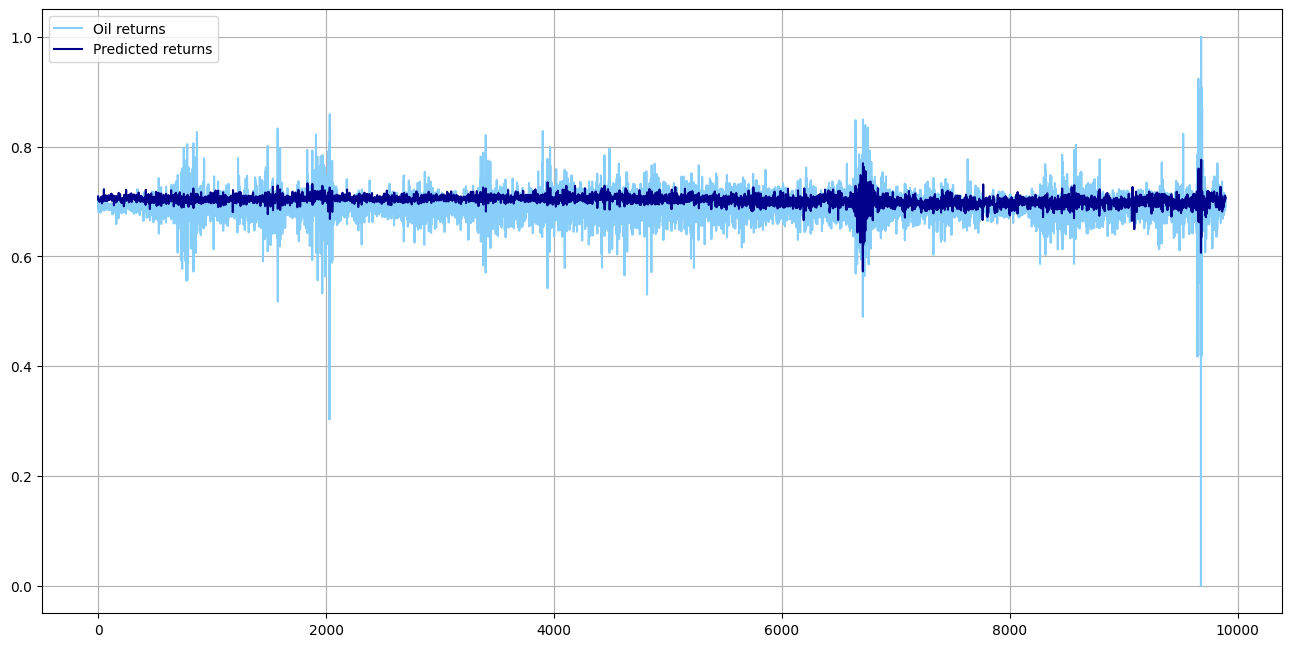

In [856]:
test_df_cnn_multivariate = pd.DataFrame()
y_pred_train = cnn_multivariate.predict(X_train)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train, (1, y_train.shape[0]))
test_df_cnn_multivariate['Prediction'] = y_pred_train[0].tolist()
test_df_cnn_multivariate['Reality'] = y_train_real[0].tolist()


plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

16/16 [==============================] - 0s 2ms/step


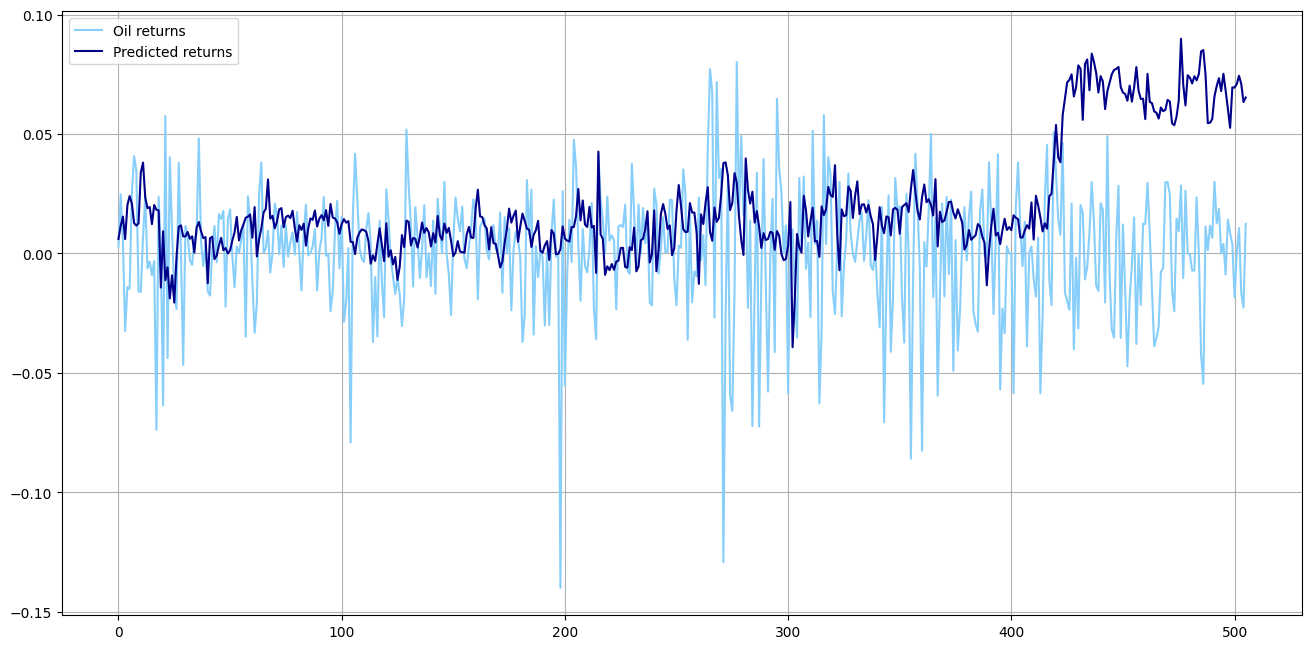

In [998]:
# Pfrediction for out of sample period
test_df_cnn_multivariate = pd.DataFrame()
y_pred_test = cnn_multivariate.predict(X_test)
y_pred_test = np.repeat(y_pred_test, train.shape[1], axis=-1)
y_pred_test = scaler.inverse_transform(y_pred_test)[:,0]

y_test_real = y_test.reshape((y_test.shape[0], 1))
y_test_real = np.repeat(y_test_real, train.shape[1], axis=-1)
y_test_real = scaler.inverse_transform(y_test_real)[:,0]

y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_real, (1, y_test_real.shape[0]))
test_df_cnn_multivariate['Prediction'] = y_pred_test[0].tolist()
test_df_cnn_multivariate['Reality'] = y_test_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

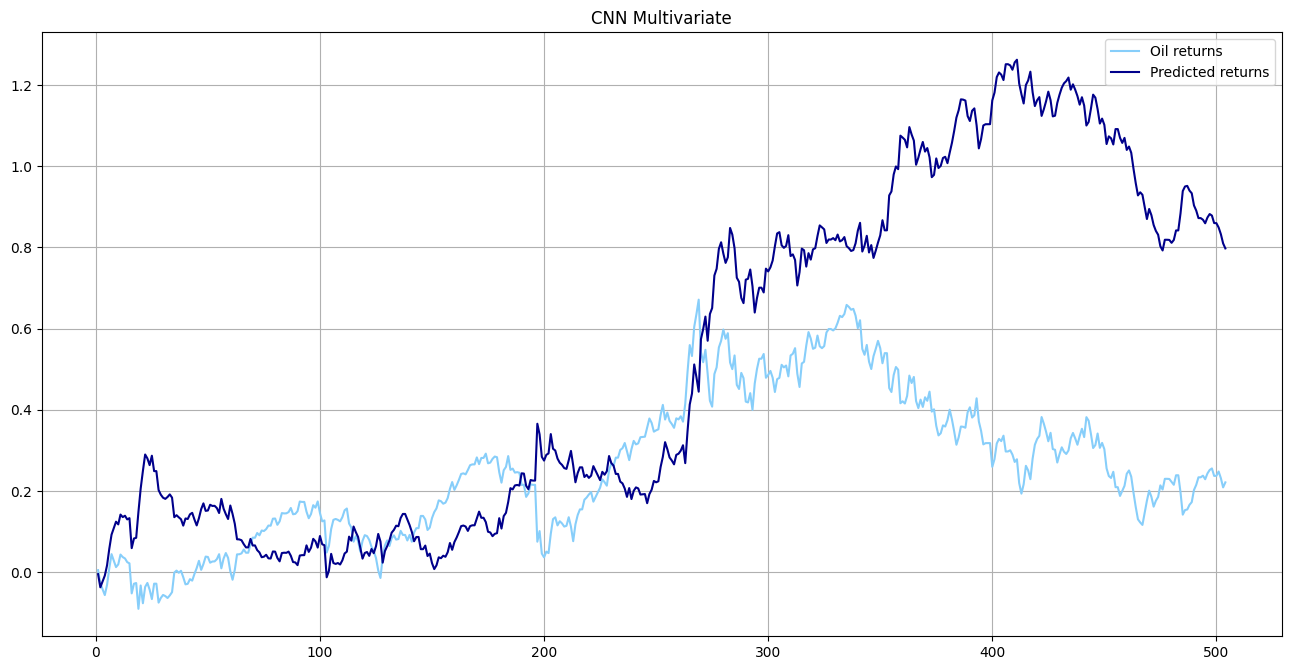

In [999]:

test_df_cnn_multivariate.dropna(inplace=True)

test_df_cnn_multivariate['Oil_returns'] = test_df_cnn_multivariate['Reality'].shift(-1)
test_df_cnn_multivariate['Predicted_returns'] = test_df_cnn_multivariate['Prediction'].shift(-1)

test_df_cnn_multivariate['Signal_predicted'] = np.where(test_df_cnn_multivariate['Predicted_returns'] > test_df_cnn_multivariate['Predicted_returns'].shift(-1), 1, -1)
test_df_cnn_multivariate['Signal_real'] = np.where(test_df_cnn_multivariate['Oil_returns'] > test_df_cnn_multivariate['Oil_returns'].shift(-1),1, -1)


test_df_cnn_multivariate['Strategy_returns'] = test_df_cnn_multivariate['Signal_predicted'].shift(1) * test_df_cnn_multivariate['Oil_returns']   
test_df_cnn_multivariate.dropna(inplace=True)


test_df_cnn_multivariate['Cumulative_real'] = test_df_cnn_multivariate['Oil_returns'].cumsum()
test_df_cnn_multivariate['Cumulative_strategy'] = test_df_cnn_multivariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_multivariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_multivariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('CNN Multivariate')
plt.legend(loc='best')

In [1000]:
#OK
test_df_cnn_multivariate1 = sharpe_ratio(test_df_cnn_multivariate, 'Cumulative_strategy', 504, 0.001)


test_df_cnn_multivariate1['Avg_daily_returns'] = test_df_cnn_multivariate1['Strategy_returns'].mean()
test_df_cnn_multivariate1['St_dev_of_return'] = test_df_cnn_multivariate1['Strategy_returns'].std()

In [1003]:
# Regression

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')

ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])
# test = data[-246:]
# test.reset_index(inplace=True)





In [1004]:
test = df_multivariate[-test_df_cnn_multivariate.shape[0]:]
test.reset_index(inplace=True)
test_df_cnn_multivariate['Date'] = test['Date']
test_df_cnn_multivariate['Date'] = pd.to_datetime(test_df_cnn_multivariate['Date'])
test_df_cnn_multivariate_regr_df = pd.merge(test_df_cnn_multivariate, ff_regression_df, on='Date', how='left')
test_df_cnn_multivariate_regr_df.fillna(0, inplace=True)

In [1005]:
# Rgression on market factors
y = test_df_cnn_multivariate_regr_df[['Strategy_returns']]
X = test_df_cnn_multivariate_regr_df[[ 'Mkt-RF', 'SMB', 'HML', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_cnn_multivariate_regr = model.fit() 
test_df_cnn_multivariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.169
Date:                Mon, 22 May 2023   Prob (F-statistic):             0.0356
Time:                        11:29:38   Log-Likelihood:                 1122.0
No. Observations:                 504   AIC:                            -2228.
Df Residuals:                     496   BIC:                            -2194.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0014      0.001      1.225      0.221      -0.001       0.004
Mkt-RF          0.0022      0.001      1.943      0.053   -2.51e-05       0.004
SMB            -0.0033      0.002     -1.565      0.118      -0.007       0.001
HML             0.0022      0.003      0.865      0.388      -0.003       0.007
Mom            -0.0006      0.001     -0.496      0.620      -0.003       0.002
LT_Rev         -0.0010      0.003     -0.345      0.730      -0.007       0.005
ST_Rev         -0.0013      0.001     -1.033      0.302      -0.004       0.001
Oil_returns    -0.0942      0.044     -2.120      0.035      -0.182      -0.007
==============================================================================
Omnibus:                       40.327   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.930
Skew:                           0.359   Prob(JB):                     3.00e-25
Kurtosis:                       5.205   Cond. No.                         73.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [865]:
# Regression on oil factors

# Momentum strategy

window = 30
momentum_df =  df_multivariate[['c1']]
#momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['c1'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["c1"]
momentum_df = momentum_df[-test_df_cnn_multivariate.shape[0]:]




In [866]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_cnn_multivariate.shape[0]:]




In [867]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["c1"] * strategies_df["carry"]
# Regression on both of strategies
test_df_cnn_multivariate.reset_index(inplace=True, drop=True)
strategies_df.reset_index(inplace=True, drop=True)
y = test_df_cnn_multivariate[['Strategy_returns']]
X = strategies_df[['c1', 'Strat_real_carry', 'Strat_real_mom']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

test_df_cnn_multivariate_regr_mom = model.fit() 

test_df_cnn_multivariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.415
Date:                Sun, 21 May 2023   Prob (F-statistic):            0.00446
Time:                        19:52:39   Log-Likelihood:                 1121.0
No. Observations:                 504   AIC:                            -2234.
Df Residuals:                     500   BIC:                            -2217.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0017      0.001      1.439      0.151      -0.001       0.004
c1                  -0.0979      0.044     -2.222      0.027      -0.185      -0.011
Strat_real_carry     0.0290      0.044      0.657      0.511      -0.058       0.116
Strat_real_mom       0.1257      0.044      2.851      0.005       0.039       0.212
==============================================================================
Omnibus:                       34.237   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.707
Skew:                           0.299   Prob(JB):                     1.22e-20
Kurtosis:                       5.003   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [724]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [309]:
# Functions
def time_idx_func(x: pd.DataFrame, date_column: str) -> pd.DataFrame:

    date_range = pd.date_range(
        start=x[date_column].min(),
        end=x[date_column].max(),
        freq='D'
    )

    date_range_df = pd.DataFrame({
        date_column: date_range
    })

    date_range_df[date_column] = date_range_df[date_column]
    date_range_df['time_idx'] = date_range_df.index

    x = pd.merge(x, date_range_df, on=[date_column], how='left')

    return x


def make_category_type(df: pd.DataFrame, column: str) -> pd.DataFrame:

    df[column] = df[column].astype(str).astype('category')

    return df


def make_log_columns(df: pd.DataFrame, column: str) -> pd.DataFrame:

    df[column] = np.log(df[column] + 1e-8)

    return df 


def rescale_columms(df: pd.DataFrame, column: str) -> pd.DataFrame:

    df[column] = df[column] / 100

    return df


def radial_basis(df: pd.DataFrame, n_periods: int, time_column: str) -> pd.DataFrame:

    
    date_cols = [ "ds"+str(a) for a in list(range(0, n_periods))] 
        
    rbf = RepeatingBasisFunction(n_periods=n_periods,
                                    remainder='passthrough',
                                    column=time_column,
                                    input_range=None)

    rbf.fit(df[[time_column]])

    dates = pd.DataFrame(index=df.index,
                            df=rbf.transform(df[[time_column]]),
                            columns=date_cols)

    return dates



def split_dataset(df: pd.DataFrame, max_encoder_length: int, max_prediction_length: int, training_cutoff: int, first_new: int ,features: list(), categorical_features: list(), group_id_features: list()):

    '''

    '''
    
    training_dataset = TimeSeriesDataSet(

        df[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="y",
            group_ids=group_id_features,
            categorical_encoders={},
            time_varying_known_categoricals=categorical_features, 
            time_varying_unknown_reals=["y"],
            time_varying_known_reals = features,
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length)


    validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, df[lambda x: x.time_idx < first_new], min_prediction_idx=training_cutoff + 1)

    return training_dataset, validation_dataset


def create_dataloaders(training_dataset, validation_dataset, batch_size):

    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    return train_dataloader, val_dataloader


def plot_predictions(model, dates_index, predictions):

    model.plot_prediction(dates_index, predictions, idx=0, add_loss_to_title=True)

    plt.show()



def optimize_hyperparams(train_dataloader, val_dataloader, n_trials, n_epochs, model_epochs):

    study = optimize_hyperparameters(

    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=n_trials,
    max_epochs=n_epochs,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  
    )

    
    with open("test_study.pkl", "wb") as fout:
        pickle.dump(study, fout)

    best_params_model = study.best_trial.params
    trainer_params = {'gradient_clip_val':best_params_model['gradient_clip_val'], 'max_epochs':model_epochs}
    best_params_model.pop('gradient_clip_val')
    model_params = best_params_model

    return model_params, trainer_params


def train_model(training_dataset, model_hyperparams,  trainer_hyperparams, train_dataloader, val_dataloader):

    results = pd.DataFrame()

    checkpoint_callback = ModelCheckpoint(dirpath='chkp/', monitor='val_loss', verbose=True, filename='{epoch}-{val_loss:.2f}', save_last=None, save_top_k=1)

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=10, verbose=True, mode="min")

    lr_logger = LearningRateMonitor() 
    logger = TensorBoardLogger("lightning_logs") 
    
    trainer = pl.Trainer(
        **trainer_hyperparams,
        gpus=0,
        enable_model_summary=True,
    
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        
        logger=logger,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training_dataset,
        **model_hyperparams, # set to <= hidden_size
        
        loss=RMSE(), # replace with quantile lossa
        # reduce learning rate if no improvement in validation loss after x epochs
        reduce_on_plateau_patience=4,
    )

    trainer.fit(
                tft,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader,
            )

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

  # raw predictions are a dictionary from which all kind of information including quantiles can be extracted
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
    b = raw_predictions.prediction[:,:,0].cpu().detach().numpy()[0]

    df = pd.DataFrame({'time_idx':x['decoder_time_idx'][0],'prediction':b},columns=['time_idx','prediction'])

    results = pd.concat([results, df], axis=0)

    return results

    
def evaluate_results(results, test_data):

    test_data = test_data[['time_idx', 'y', 'Date']]
    results = results.merge(test_data, on = 'time_idx', how = 'left')

    return results

def evaluate_error(df, predicted, real):

    df['error'] = ((df[real] - df[predicted])/df[real]).abs()

    df['mape'] = np.mean(df['error'])

    return df 


def plot_strategies(preds, real_returns_cum, strategy_returs_cum):

  plt.figure(figsize=(16,8))

  plt.plot(preds[real_returns_cum], color='orange', label='Oil futures returns')

  plt.plot(preds[strategy_returs_cum], color='grey', label='Strategy returns')

  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

# NHiTS

In [310]:
# FUNCTIONS

def split_dataset_nhits(df: pd.DataFrame, max_encoder_length: int, max_prediction_length: int, training_cutoff: int, first_new: int ,features: list(), categorical_features: list(), group_id_features: list()):

    '''

    '''
    
    training_dataset = TimeSeriesDataSet(

        df[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="y",
            group_ids=group_id_features,
            categorical_encoders={},
            time_varying_known_categoricals=categorical_features, 
            time_varying_unknown_reals=["y"],
            time_varying_known_reals = features,
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length,
            allow_missing_timesteps=True,
            add_relative_time_idx=False, )

    validation_dataset = validation = TimeSeriesDataSet.from_dataset(training_dataset, df, min_prediction_idx=training_cutoff + 1)

    return training_dataset, validation_dataset

def optimize_hyperparams_nhits(train_dataloader, val_dataloader, n_trials, n_epochs, model_epochs):

    study = optimize_hyperparameters(

    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=n_trials,
    max_epochs=n_epochs,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  
    
    )

    with open("test_study.pkl", "wb") as fout:
        pickle.dump(study, fout)

    best_params_model = study.best_trial.params
    trainer_params = {'gradient_clip_val':best_params_model['gradient_clip_val'], 'max_epochs':model_epochs}
    best_params_model.pop('gradient_clip_val')
    best_params_model.pop('hidden_continuous_size')
    best_params_model.pop('attention_head_size')
    model_params = best_params_model

    return model_params, trainer_params


def train_model_nhits(training_dataset, model_hyperparams,  trainer_hyperparams, train_dataloader, val_dataloader):
    results = pd.DataFrame()

    checkpoint_callback = ModelCheckpoint(dirpath='chkp/', monitor='val_loss', verbose=True, filename='{epoch}-{val_loss:.2f}', save_last=None, save_top_k=1)

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=True, mode="min")
    
    trainer = pl.Trainer(
                **trainer_hyperparams,
                gpus=0,
                enable_model_summary=True,
                
                callbacks=[early_stop_callback, checkpoint_callback], 
                limit_train_batches=128,
                enable_checkpointing=True
            )

    net = NHiTS.from_dataset(
                training_dataset,
                **model_hyperparams,
                loss=RMSE(),
            )

    trainer.fit(
                net,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader,
            )

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = NHiTS.load_from_checkpoint(best_model_path)

  
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
    b = raw_predictions.prediction[:,:,0].cpu().detach().numpy()[0]

    df = pd.DataFrame({'time_idx':x['decoder_time_idx'][0],'prediction':b},columns=['time_idx','prediction'])

    results = pd.concat([results, df], axis=0)

    return results

def evaluate_results(results, test_data):

    test_data = test_data[['time_idx', 'y', 'Date']]
    results = results.merge(test_data, on = 'time_idx', how = 'left')

    return results

def evaluate_error(df, predicted, real):

    df['error'] = ((df[real] - df[predicted])/df[real]).abs()

    df['mape'] = np.mean(df['error'])

    return df 

    



In [774]:
from pytorch_lightning.callbacks import EarlyStopping

In [779]:
data = pd.read_parquet('oil_best_feats_v3.parquet')
data.columns

Index(['Date', 'c1', 'Spread', 'NCL_LTD', 'Shift', 'Year', 'Month', 'Quarter',
       'Day', 'Week', 'DGS1', 'DGS10', 'VIXCLS', 'Inventories', 'Rig_actual',
       'Prod_actual', 'GDP', 'CPIAUCSL', 'Return_sp', 'Return_nasdaq',
       'Fin_Score', 'Sentiment_label', 'Sentiment_present', 'Trend'],
      dtype='object')

In [782]:
# No For loop 
MAX_ENCODER_LENGTH = 1008
MAX_PREDICTION_LENGTH = 504
BATCH_SIZE = 128
FEATURE_LIST = ['Spread', 'NCL_LTD', 'Shift',  'DGS1', 'DGS10', 'VIXCLS', 'Inventories', 'Rig_actual',
       'Prod_actual', 'GDP', 'CPIAUCSL', 'Return_sp', 'Return_nasdaq',
       'Fin_Score', 'Sentiment_label', 'Sentiment_present', 'Trend']
CATEGORICAL_FEATURES_LIST = []#['Day', 'Month', 'Week']
GROUP_ID_FEATURES = ['Cat']

MODEL_HYPERPARAMS = {
                'learning_rate':0.01,
                'dropout':0.05,       
                # 'log_interval':10,
                # 'log_val_interval':1,
                'hidden_size':64,
                #'hidden_continuous_size':32,
                #'reduce_on_plateau_patience':10,
                #'attention_head_size':1
}

TRAINER_HYPERPARAMS = {
    'max_epochs':100, 
    'gradient_clip_val': 1.0,
}

data = pd.read_parquet('oil_best_feats_v3.parquet')
data = data.reset_index()
data.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)

data = make_category_type(data, 'Month')

#data = make_category_type(data, 'Day')

data = data.reset_index(drop=True)
data['Cat'] = 'Cat'



data['y'] = np.log(data['y']) - np.log(data['y'].shift(1))
data.dropna(inplace=True)
data['y'][-504:] = 0

data1 = data.copy()

first_new = 9891 #data1[data1['y'] == 0]['time_idx'].min()



training_cutoff = data1["time_idx"].max() - MAX_PREDICTION_LENGTH

training_dataset, validation_dataset = split_dataset_nhits(data1, MAX_ENCODER_LENGTH, MAX_PREDICTION_LENGTH, training_cutoff=training_cutoff, first_new=first_new, features=FEATURE_LIST, categorical_features=CATEGORICAL_FEATURES_LIST, group_id_features=GROUP_ID_FEATURES)

training_dataloader, val_dataloader = create_dataloaders(training_dataset=training_dataset, validation_dataset=validation_dataset, batch_size=BATCH_SIZE)
#model_params, trainer_params = optimize_hyperparams_nhits(train_dataloader=training_dataloader, val_dataloader=val_dataloader, n_epochs=1, n_trials=1,model_epochs=1)
import torch
torch.manual_seed(0)

results = train_model_nhits(training_dataset, MODEL_HYPERPARAMS, TRAINER_HYPERPARAMS, train_dataloader=training_dataloader, val_dataloader=val_dataloader)





  

  

  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | RMSE           | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 10.5 M
---------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.056    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.017
Epoch 0, global step 65: 'val_loss' reached 0.01666 (best 0.01666), saving model to '/Users/rustamibragimov/of/chkp/epoch=0-val_loss=0.02.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 130: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 195: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.016
Epoch 3, global step 260: 'val_loss' reached 0.01558 (best 0.01558), saving model to '/Users/rustamibragimov/of/chkp/epoch=3-val_loss=0.02.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.015
Epoch 4, global step 325: 'val_loss' reached 0.01469 (best 0.01469), saving model to '/Users/rustamibragimov/of/chkp/epoch=4-val_loss=0.01.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 390: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 455: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 520: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.001
Epoch 8, global step 585: 'val_loss' reached 0.00148 (best 0.00148), saving model to '/Users/rustamibragimov/of/chkp/epoch=8-val_loss=0.00-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 650: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 715: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 780: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 845: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 910: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 975: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1040: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1105: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1170: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1235: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 1300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 1365: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 1430: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 1495: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1560: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1625: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 1690: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 1755: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 1820: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.001. Signaling Trainer to stop.
Epoch 28, global step 1885: 'val_loss' was not in top 1


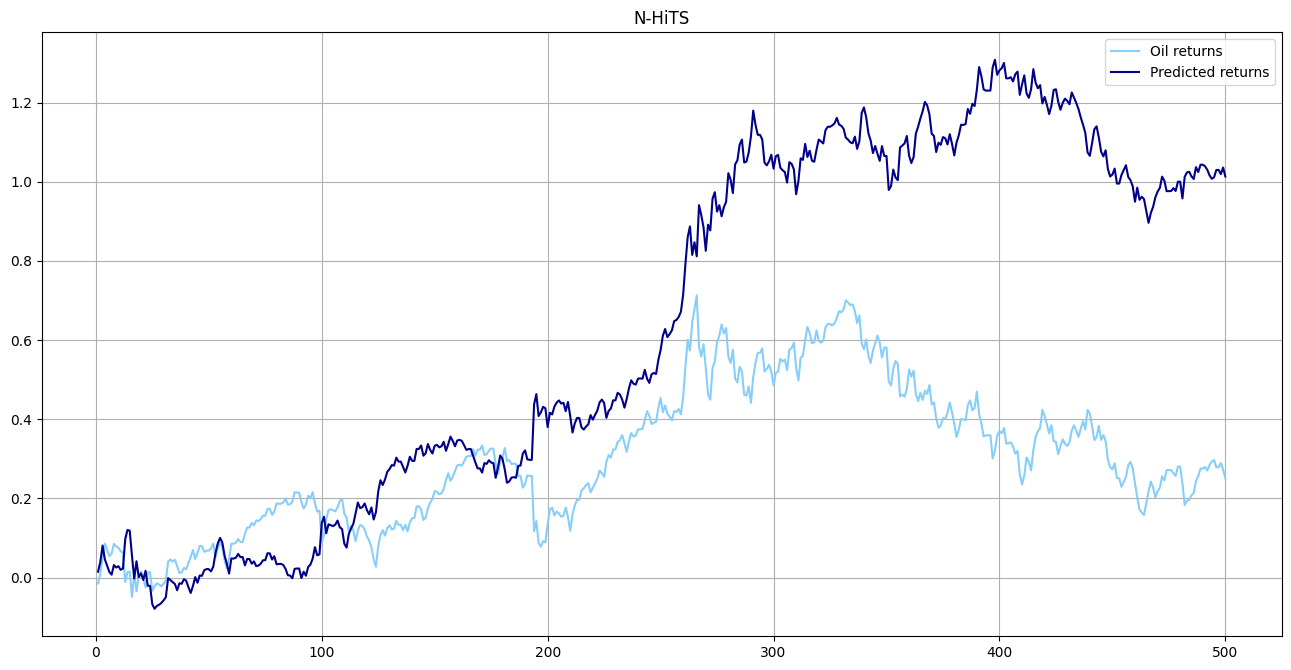

In [1215]:

# test = pd.read_parquet('oil_best_feats_v3.parquet')
# test = test.reset_index()
# test.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)
# test['y'] = np.log(test['y']) - np.log(test['y'].shift(1))
# test.dropna(inplace=True)

# results1 = pd.merge(results, test[['time_idx', 'y', 'Date']], on='time_idx', how='left')


# results1.dropna(inplace=True)

results1['Oil_returns'] = results1['y'].shift(-1)
results1['Predicted_returns'] = results1['prediction'].shift(-1)

results1['Signal_predicted'] = np.where(results1['Predicted_returns'] > results1['Predicted_returns'].shift(-1), 1, -1)
results1['Signal_real'] = np.where(results1['Oil_returns'] > results1['Oil_returns'].shift(-1),1, -1)

results1['Strategy_returns'] = results1['Signal_predicted'].shift(1) * results1['Oil_returns']    
results1.dropna(inplace=True)


results1['Cumulative_real'] = results1['Oil_returns'].cumsum()
results1['Cumulative_strategy'] = results1['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(results1['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(results1['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('N-HiTS')
plt.legend(loc='best')

In [1216]:
#OK
results1 = sharpe_ratio(results1, 'Cumulative_strategy', 504, 0.001)

results1['Avg_daily_returns'] = results1['Strategy_returns'].mean()
results1['St_dev_of_return'] = results1['Strategy_returns'].std()

In [1295]:
rmse_test1 = math.sqrt(mean_squared_error(results1.prediction, results1.y))
rmse_test1

0.026705050163151164

In [1304]:
results_tr = pd.DataFrame()
best_model_path =  '/Users/rustamibragimov/of/chkp/epoch=8-val_loss=0.00-v1.ckpt'
best_tft = NHiTS.load_from_checkpoint(best_model_path)
raw_predictions, x = best_tft.predict(training_dataloader, mode="raw", return_x=True)
b = raw_predictions.prediction[:,:,0].cpu().detach().numpy()[0]
df = pd.DataFrame({'time_idx':x['decoder_time_idx'][0],'prediction':b},columns=['time_idx','prediction'])

results_tr = pd.concat([results_tr, df], axis=0)

In [1309]:
test = pd.read_parquet('oil_best_feats_v3.parquet')
test = test.reset_index()
test.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)
test['y'] = np.log(test['y']) - np.log(test['y'].shift(1))
test.dropna(inplace=True)

results_tr1 = pd.merge(results_tr, test[['time_idx', 'y', 'Date']], on='time_idx', how='left')


results_tr1.dropna(inplace=True)

results_tr1['Oil_returns'] = results_tr1['y'].shift(-1)
results_tr1['Predicted_returns'] = results_tr1['prediction'].shift(-1)

results_tr1['Signal_predicted'] = np.where(results_tr1['Predicted_returns'] > results_tr1['Predicted_returns'].shift(-1), 1, -1)
results_tr1['Signal_real'] = np.where(results_tr1['Oil_returns'] > results_tr1['Oil_returns'].shift(-1),1, -1)

results_tr1['Strategy_returns'] = results_tr1['Signal_predicted'].shift(1) * results_tr1['Oil_returns']    
results_tr1.dropna(inplace=True)


results_tr1['Cumulative_real'] = results_tr1['Oil_returns'].cumsum()
results_tr1['Cumulative_strategy'] = results_tr1['Strategy_returns'].cumsum()



In [1308]:
results_tr1.head()
rmse_tr = math.sqrt(mean_squared_error(results_tr1.prediction, results_tr1.y))
rmse_tr

0.01720027927249149

In [1219]:
# Regression with marker factors
# Regression

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')

ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])
# test = data[-246:]
# test.reset_index(inplace=True)




results1['Date'] = pd.to_datetime(results1['Date'])
results1_regr_df = pd.merge(results1, ff_regression_df, on='Date', how='left')
results1_regr_df.fillna(0, inplace=True)






In [1220]:
# Rgression on market factors
y = results1_regr_df[['Strategy_returns']]
X = results1_regr_df[[ 'Mkt-RF','SMB', 'HML', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
nhits_regr = model.fit() 
nhits_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.341
Date:                Mon, 22 May 2023   Prob (F-statistic):              0.229
Time:                        16:58:49   Log-Likelihood:                 1109.8
No. Observations:                 500   AIC:                            -2204.
Df Residuals:                     492   BIC:                            -2170.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0021      0.001      1.790      0.074      -0.000       0.004
Mkt-RF         -0.0020      0.001     -1.742      0.082      -0.004       0.000
SMB             0.0035      0.002      1.640      0.102      -0.001       0.008
HML             0.0033      0.003      1.289      0.198      -0.002       0.008
Mom            -0.0003      0.001     -0.241      0.810      -0.003       0.002
LT_Rev         -0.0034      0.003     -1.127      0.260      -0.009       0.003
ST_Rev         -0.0009      0.001     -0.688      0.492      -0.003       0.002
Oil_returns    -0.0638      0.045     -1.413      0.158      -0.153       0.025
==============================================================================
Omnibus:                       44.034   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.981
Skew:                           0.423   Prob(JB):                     2.40e-26
Kurtosis:                       5.225   Cond. No.                         74.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1221]:
# Regression on oil factors

# Momentum strategy
test = pd.read_parquet('oil_best_feats_v3.parquet')
test = test.reset_index()
test.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)
test['y'] = np.log(test['y']) - np.log(test['y'].shift(1))

test.dropna(inplace=True)



window = 30
momentum_df =  test[['y' ,'Date']]
#momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['y'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["y"]
momentum_df = momentum_df[-results1.shape[0]:]




In [1222]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-results1.shape[0]:]




In [1223]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["y"] * strategies_df["carry"]
# Regression on both of strategies
results1.reset_index(inplace=True, drop=True)
strategies_df.reset_index(inplace=True, drop=True)
y = results1[['Strategy_returns']]
X = strategies_df[['y', 'Strat_real_carry', 'Strat_real_mom']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

test_df_cnn_multivariate_regr_mom = model.fit() 

test_df_cnn_multivariate_regr_mom.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.806
Date:                Mon, 22 May 2023   Prob (F-statistic):             0.0392
Time:                        16:58:53   Log-Likelihood:                 1109.3
No. Observations:                 500   AIC:                            -2211.
Df Residuals:                     496   BIC:                            -2194.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0020      0.001      1.650      0.100      -0.000       0.004
y                    0.1276      0.044      2.872      0.004       0.040       0.215
Strat_real_carry     0.0171      0.044      0.384      0.701      -0.070       0.104
Strat_real_mom      -0.0008      0.044     -0.017      0.986      -0.088       0.087
==============================================================================
Omnibus:                       58.663   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.582
Skew:                           0.542   Prob(JB):                     7.46e-39
Kurtosis:                       5.693   Cond. No.                         38.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""